In [1]:
%pylab inline
import pandas as pd
import sys
import gc
import lightgbm as lgb

Populating the interactive namespace from numpy and matplotlib


In [2]:
sys.path.insert(0,"../python/rrvf2017/")

In [3]:
from rrvf_data import read_data,show_data,show_data2,show_features, normalize, DataGen

In [4]:
columns,data=read_data()
len(columns),data.shape

(1, 829, 517) (54, 829, 517)


(62, (829, 517, 62))

In [5]:
gc.collect()

15

In [6]:
#show_data(data,columns, 1,480, None)

In [7]:
#show_data2(data,columns)

# cv

In [8]:
n_reg_lookback=28

In [9]:
def get_index(cols):
    lst=[]
    for c in cols:
        lst.append(np.where(columns==c)[0][0])
    return np.array(lst)

In [10]:
rawy=data[:,:,get_index(['visitors'])[0]].copy()
rawy.shape

(829, 517)

In [11]:
lag_cols=array(['visitor_ma28', 'visitor_ma56', 'visitor_ma14', 'visitor_ma112', 'visitor_ma224', 'visitor_sma8', 'visitor_sma4', 'visitor_sma3', 'visitor_sma16', 'visitor_sma2', 'visitor_ma4', 'visitor_ma2', 'visitors', 'visitor_lag7', 'visitor_lag14', 'visitor_lag28', 'visitor_lag91', 'visitor_lag182', 'visitor_lag364', 'geo2_visitors_mean', 'all_count_y1', 'geo1_visitors_mean', 'all_count_y3', 'day_of_week_visitors_mean', 'station_count_y2', 'all_count_y5'])
len(lag_cols)

26

In [12]:
def make_ondate_train_test(ondate_cols):
    ondate_train_test=data[:,:,get_index(ondate_cols)].copy()
    ondate_train_test=normalize(ondate_train_test)
    print ondate_train_test.shape
    return ondate_train_test

In [13]:
ondate_cols =array(['const_one', 'visitor_lag91', 'weekday6', 'holiday', 'TMAX'])

In [14]:
def make_lag_train_test(lag_cols):
    lag_train_test=data[:,:,get_index(lag_cols)].copy()
    #lag_train_test=normalize(lag_train_test)
    print lag_train_test.shape
    return lag_train_test

In [15]:
from sklearn.model_selection import GridSearchCV,ParameterGrid,ParameterSampler
from sklearn.metrics import  make_scorer
from multiprocessing import Pool

In [16]:
from keras.callbacks import EarlyStopping
from keras.models import Sequential
from keras.layers import Dense, Activation, InputLayer, Dropout,BatchNormalization
from keras import metrics,backend,regularizers, backend as K, losses
import keras
import tensorflow as tf
from keras.engine.topology import Layer
from keras.backend.tensorflow_backend import set_session
print K.floatx()

Using TensorFlow backend.


float32


In [17]:
config = tf.ConfigProto()
config.gpu_options.per_process_gpu_memory_fraction = 0.5
#config.intra_op_parallelism_threads=8
#config.inter_op_parallelism_threads=8
set_session(tf.Session(config=config))

# time split

In [18]:
import cPickle as pickle
indexes=[pickle.load(open(u)) for  u in ['train_idx_1.pkl','train_idx_2.pkl','train_idx_3.pkl']]

In [19]:
param_grid={
            'metric':['mean_squared_error' ],
            'loss':['mean_squared_error'],
            "patience":[5],
            "activation":['relu'],    
            "l2":[1e-6,0],
            'batch_normalization': [False],
            "optimizer":['adam','adam','adagrad']
           }
parameters=list(ParameterGrid(param_grid))
parameter=parameters[0]
len(parameters),parameter

(6,
 {'activation': 'relu',
  'batch_normalization': False,
  'l2': 1e-06,
  'loss': 'mean_squared_error',
  'metric': 'mean_squared_error',
  'optimizer': 'adam',
  'patience': 5})

In [20]:
import rrvf_model as  rrvf
reload(rrvf)

<module 'rrvf_model' from '../python/rrvf2017/rrvf_model.pyc'>

In [21]:
from sklearn.metrics import mean_squared_error

In [22]:
def predict_test(self,test_gen):
    X, y, mask,w =test_gen.get_train()
    filenames = self.best_epoch
    aa = rrvf.make_pred(filenames, X)
    aa = np.array(aa)
    yy_pred = np.sum(aa * self.get_weights().reshape([-1, 1, 1]), 0)
    print yy_pred.shape, np.mean(yy_pred), w.shape
    return yy_pred, w, y, mask,X
def g(a,test_gen):
    result=predict_test(a,test_gen)
    df=pd.DataFrame({'y':result[2][:,0]})
    df['pred']=result[0][:,0]
    df['dayidx']=result[1][:,1]
    df=df.loc[df['y']>0]
    df['error']=df['y']-df['pred']
    df['error2']=df['error']**2
    df['day']=pd.to_datetime(rrvf_data.idx_to_date(df['dayidx'])).map(lambda u: u.weekday+1)
    df2=df.groupby("dayidx").mean() 
    df2['date']=pd.to_datetime(rrvf_data.idx_to_date(df2.index)).map(lambda u: u.date())
    display(df2)
    return  df2['error2'].mean()
def h(self,train_gen):
    Xdict,_,dataidx,_=train_gen.get_by_t2(day=478-39)
    filenames = self.best_epoch
    aa = rrvf.make_pred(filenames, Xdict)
    aa = np.array(aa)
    yy_pred = np.sum(aa * self.get_weights().reshape([-1, 1, 1]), 0)
    print yy_pred.shape, np.mean(yy_pred), 
    return yy_pred, dataidx


In [23]:
reload(rrvf)
import rrvf_data
def _run_once(index, ondate_cols,lag_cols,n_lookforward,n_offset):
    batchsize=128
    ondate_train_test=make_ondate_train_test(ondate_cols)
    lag_train_test = make_lag_train_test(lag_cols)
    train_gen=DataGen(lag_train_test,ondate_train_test, rawy,n_reg_lookback+1, 478-1*7-39-n_offset, 
                      batchsize=batchsize,valid_split=0.1, indexes=index,lookforward_offset=n_offset,
                  lookback1=n_reg_lookback,  lookforward=n_lookforward)
    valid_gen=None
    test_gen=DataGen(lag_train_test,ondate_train_test, rawy,478-1*7-n_offset,478, lookforward_offset=n_offset,
                     batchsize=batchsize,lookback1=n_reg_lookback, lookforward=n_lookforward)
    print train_gen.train_steps_per_epoch
    print 0 if valid_gen is None else valid_gen.train_steps_per_epoch
    
    lag_input_dim=lag_train_test.shape[-1]
    ondate_input_dim=ondate_train_test.shape[-1]
    print lag_input_dim,ondate_input_dim,(n_lookforward,ondate_input_dim)
    backend.clear_session()
    set_session(tf.Session(config=config))   
    a=rrvf.KerasModel("testconv", n_lookforward=n_lookforward,n_reg_lookback=n_reg_lookback,
                      ondate_input_dim=ondate_input_dim, lag_input_dim=lag_input_dim, n_offset=n_offset,
                      max_epoch=100, use_output_exp=True,use_dropout=False,model_type="conv",
                      params=parameter)
    a._make_model()
    print a.params
    print a.model.count_params()
    a.fit(train_gen,valid_gen)
    if a.model.abnormal_stop:
        return np.inf,None,None
    valid_loss,validy,validpred,valididx=a.eval_valid()
    print valid_loss
    g(a,test_gen)
    pred478=h(a,train_gen)
    return valid_loss,(validy,valididx,validpred),pred478



def run_once(index, ondate_cols,lag_cols,n_lookforward,n_offset):
    while 1:
        ret=_run_once(index, ondate_cols,lag_cols,n_lookforward,n_offset)
        if ret[0]<1:
            return ret
        else:
            print "bad init,try again."
        

In [24]:
def MSE(a,b):
    idx= np.isnan(a) | np.isnan(b)
    a=a[~idx]
    b=b[~idx]
    #print np.mean(~idx)
    return np.mean((a-b)**2)
    return mean_squared_error(a,b)

In [25]:
reload(rrvf)
j=0
validpreds={}
for offset in range(1,40):
    print "\n\n",offset
    _,validpred,pred478=run_once(indexes[j],ondate_cols,lag_cols,n_lookforward=offset,n_offset=offset-1)
    validpreds[offset]=[validpred,pred478]
    pickle.dump(validpreds, open('conv_valid{}_preds_tmp.pkl'.format(j),'wb'))



1
(5,) 0.0676983 19.316
(829, 517, 5)
(829, 517, 26)
rand split across time
train has 301041 records out of 334087 records
valid has 33046 records out of 334087 records
train has 5803 records out of 5803 records
no valid set
2351
0
26 5 (1, 5)
input_x_trans shape: (?, 28, 52)
(?, 896)
(?, 1, 896)
{'loss': 'mean_squared_error', 'optimizer': 'adam', 'activation': 'relu', 'patience': 5, 'l2': 1e-06, 'batch_normalization': False, 'metric': 'mean_squared_error'}
367619
Epoch 1/100
2350/2351 [============================>.] - ETA: 0s - loss: 3.7180 - total_loss: 3.7180 - reg_loss: 3.7180Epoch 00001: saving model to testconv/model_adam.001.h5
epoch 0: Invalid loss, terminating training
2351/2351 [==============================] - 36s 15ms/step - loss: 3.7167 - total_loss: 3.7167 - reg_loss: 3.7167 - val_loss: 0.9687 - val_total_loss: 0.9687 - val_reg_loss: 0.9687
best_epochs [1]
individual loss [ 0.96927484]
[ 1.] 0.96927484138
bad init,try again.
(5,) 0.0676983 19.316
(829, 517, 5)
(829, 5

Epoch 15/100
2351/2351 [==============================] - 34s 15ms/step - loss: 0.2671 - total_loss: 0.2671 - reg_loss: 0.2671 - val_loss: 0.2536 - val_total_loss: 0.2536 - val_reg_loss: 0.2536
Epoch 16/100
2351/2351 [==============================] - 34s 15ms/step - loss: 0.2661 - total_loss: 0.2661 - reg_loss: 0.2661 - val_loss: 0.2528 - val_total_loss: 0.2528 - val_reg_loss: 0.2528
best_epochs [11, 12, 13, 16, 9]
individual loss [ 0.25229309  0.25204111  0.25165482  0.25277638  0.25331939]
[ 0.1935484   0.24897754  0.26841254  0.25434341  0.03471811] 0.247046433499
best_epochs [11, 12, 13, 16, 9]
0.247046433491 0.247046433491
(1, 0.24704643349134173)
0.247046433491
best_epochs [11, 12, 13, 16, 9]
(5803, 1) 2.72986587944 (5803, 2)


y      pred     error    error2  day        date
dayidx                                                         
471     2.929110  2.868400  0.060710  0.269321    7  2017-04-16
472     2.507290  2.591094 -0.083804  0.262589    1  2017-04-17
473     2.661330  2.663895 -0.002565  0.282705    2  2017-04-18
474     2.754815  2.769346 -0.014531  0.240819    3  2017-04-19
475     2.713762  2.718048 -0.004286  0.258772    4  2017-04-20
476     2.999000  2.963315  0.035685  0.174567    5  2017-04-21
477     3.075529  3.126205 -0.050676  0.211732    6  2017-04-22

best_epochs [11, 12, 13, 16, 9]
(829, 1) 2.63076876261 

2
(5,) 0.0676983 19.316
(829, 517, 5)
(829, 517, 26)
rand split across time
train has 300294 records out of 333258 records
valid has 32964 records out of 333258 records
train has 6632 records out of 6632 records
no valid set
2346
0
26 5 (2, 5)
input_x_trans shape: (?, 28, 52)
(?, 896)
(?, 1, 896)
{'loss': 'mean_squared_error', 'optimizer': 'adam', 'activation': 'relu', 'patience': 5, 'l2': 1e-06, 'batch_normalization': False, 'metric': 'mean_squared_error'}
367619
Epoch 1/100
2343/2346 [============================>.] - ETA: 0s - loss: 3.7255 - total_loss: 3.7255 - reg_loss: 3.7255Epoch 00001: saving model to testconv/model_adam.001.h5
epoch 0: Invalid loss, terminating training
2346/2346 [==============================] - 35s 15ms/step - loss: 3.7219 - total_loss: 3.7219 - reg_loss: 3.7219 - val_loss: 0.9724 - val_total_loss: 0.9724 - val_reg_loss: 0.9724
best_epochs [1]
individual loss [ 0.97257802]
[ 1.] 0.972578024977
bad ini

y      pred     error    error2  day        date
dayidx                                                         
470     2.929110  2.879649  0.049461  0.266411    6  2017-04-15
471     2.507290  2.577099 -0.069808  0.266959    7  2017-04-16
472     2.661330  2.677641 -0.016311  0.282284    1  2017-04-17
473     2.754815  2.772559 -0.017744  0.239402    2  2017-04-18
474     2.713762  2.765769 -0.052008  0.267514    3  2017-04-19
475     2.999000  2.988066  0.010933  0.174073    4  2017-04-20
476     3.075529  3.148088 -0.072558  0.209713    5  2017-04-21

best_epochs [6, 11, 8, 9, 7]
(829, 1) 2.64081168186 

3
(5,) 0.0676983 19.316
(829, 517, 5)
(829, 517, 26)
rand split across time
train has 299547 records out of 332429 records
valid has 32882 records out of 332429 records
train has 7461 records out of 7461 records
no valid set
2340
0
26 5 (3, 5)
input_x_trans shape: (?, 28, 52)
(?, 896)
(?, 1, 896)
{'loss': 'mean_squared_error', 'optimizer': 'adam', 'activation': 'relu', 'patience': 5, 'l2': 1e-06, 'batch_normalization': False, 'metric': 'mean_squared_error'}
367619
Epoch 1/100
2340/2340 [==============================] - 34s 15ms/step - loss: 0.5275 - total_loss: 0.5275 - reg_loss: 0.5275 - val_loss: 0.2771 - val_total_loss: 0.2771 - val_reg_loss: 0.2771
Epoch 2/100
2340/2340 [==============================] - 34s 14ms/step - loss: 0.3041 - total_loss: 0.3041 - reg_loss: 0.3041 - val_loss: 0.2741 - val_total_loss: 0.2741 - val_reg_loss: 0.2741
Epoch 3/100
2340/2340 [==============================] - 34s 14ms/step - loss: 0.2964 - tot

y      pred     error    error2  day        date
dayidx                                                         
469     2.929110  2.887315  0.041795  0.269030    5  2017-04-14
470     2.507290  2.585521 -0.078231  0.257939    6  2017-04-15
471     2.661330  2.662229 -0.000899  0.281742    7  2017-04-16
472     2.754815  2.791313 -0.036498  0.237060    1  2017-04-17
473     2.713762  2.760823 -0.047061  0.260230    2  2017-04-18
474     2.999000  2.961169  0.037831  0.177038    3  2017-04-19
475     3.075529  3.109557 -0.034028  0.205444    4  2017-04-20

best_epochs [10, 15, 11, 12, 13]
(829, 1) 2.94061859419 

4
(5,) 0.0676983 19.316
(829, 517, 5)
(829, 517, 26)
rand split across time
train has 298800 records out of 331600 records
valid has 32800 records out of 331600 records
train has 8290 records out of 8290 records
no valid set
2334
0
26 5 (4, 5)
input_x_trans shape: (?, 28, 52)
(?, 896)
(?, 1, 896)
{'loss': 'mean_squared_error', 'optimizer': 'adam', 'activation': 'relu', 'patience': 5, 'l2': 1e-06, 'batch_normalization': False, 'metric': 'mean_squared_error'}
367619
Epoch 1/100
2333/2334 [============================>.] - ETA: 0s - loss: 3.7384 - total_loss: 3.7384 - reg_loss: 3.7384Epoch 00001: saving model to testconv/model_adam.001.h5
epoch 0: Invalid loss, terminating training
2334/2334 [==============================] - 34s 15ms/step - loss: 3.7372 - total_loss: 3.7372 - reg_loss: 3.7372 - val_loss: 0.9836 - val_total_loss: 0.9836 - val_reg_loss: 0.9836
best_epochs [1]
individual loss [ 0.98395512]
[ 1.] 0.983955121404
bad in

2332/2334 [============================>.] - ETA: 0s - loss: 3.7379 - total_loss: 3.7379 - reg_loss: 3.7379Epoch 00001: saving model to testconv/model_adam.001.h5
epoch 0: Invalid loss, terminating training
2334/2334 [==============================] - 34s 14ms/step - loss: 3.7354 - total_loss: 3.7354 - reg_loss: 3.7354 - val_loss: 0.9824 - val_total_loss: 0.9824 - val_reg_loss: 0.9824
best_epochs [1]
individual loss [ 0.98310271]
[ 1.] 0.983102714026
bad init,try again.
(5,) 0.0676983 19.316
(829, 517, 5)
(829, 517, 26)
rand split across time
train has 298800 records out of 331600 records
valid has 32800 records out of 331600 records
train has 8290 records out of 8290 records
no valid set
2334
0
26 5 (4, 5)
input_x_trans shape: (?, 28, 52)
(?, 896)
(?, 1, 896)
{'loss': 'mean_squared_error', 'optimizer': 'adam', 'activation': 'relu', 'patience': 5, 'l2': 1e-06, 'batch_normalization': False, 'metric': 'mean_squared_error'}
367619
Epoch 1/100
2331/2334 [============================>.] - E

{'loss': 'mean_squared_error', 'optimizer': 'adam', 'activation': 'relu', 'patience': 5, 'l2': 1e-06, 'batch_normalization': False, 'metric': 'mean_squared_error'}
367619
Epoch 1/100
2329/2334 [============================>.] - ETA: 0s - loss: 4.4220 - total_loss: 4.4220 - reg_loss: 4.4220Epoch 00001: saving model to testconv/model_adam.001.h5
epoch 0: Invalid loss, terminating training
2334/2334 [==============================] - 30s 13ms/step - loss: 4.4142 - total_loss: 4.4142 - reg_loss: 4.4142 - val_loss: 0.9897 - val_total_loss: 0.9897 - val_reg_loss: 0.9897
best_epochs [1]
individual loss [ 0.98933015]
[ 1.] 0.989330150536
bad init,try again.
(5,) 0.0676983 19.316
(829, 517, 5)
(829, 517, 26)
rand split across time
train has 298800 records out of 331600 records
valid has 32800 records out of 331600 records
train has 8290 records out of 8290 records
no valid set
2334
0
26 5 (4, 5)
input_x_trans shape: (?, 28, 52)
(?, 896)
(?, 1, 896)
{'loss': 'mean_squared_error', 'optimizer': 'a

best_epochs [1]
individual loss [ 0.98407108]
[ 1.] 0.984071081737
bad init,try again.
(5,) 0.0676983 19.316
(829, 517, 5)
(829, 517, 26)
rand split across time
train has 298800 records out of 331600 records
valid has 32800 records out of 331600 records
train has 8290 records out of 8290 records
no valid set
2334
0
26 5 (4, 5)
input_x_trans shape: (?, 28, 52)
(?, 896)
(?, 1, 896)
{'loss': 'mean_squared_error', 'optimizer': 'adam', 'activation': 'relu', 'patience': 5, 'l2': 1e-06, 'batch_normalization': False, 'metric': 'mean_squared_error'}
367619
Epoch 1/100
2332/2334 [============================>.] - ETA: 0s - loss: 3.7397 - total_loss: 3.7397 - reg_loss: 3.7397Epoch 00001: saving model to testconv/model_adam.001.h5
epoch 0: Invalid loss, terminating training
2334/2334 [==============================] - 34s 15ms/step - loss: 3.7372 - total_loss: 3.7372 - reg_loss: 3.7372 - val_loss: 0.9855 - val_total_loss: 0.9855 - val_reg_loss: 0.9855
best_epochs [1]
individual loss [ 0.98502887]


Epoch 15/100
2334/2334 [==============================] - 34s 14ms/step - loss: 0.2739 - total_loss: 0.2739 - reg_loss: 0.2739 - val_loss: 0.2716 - val_total_loss: 0.2716 - val_reg_loss: 0.2716
best_epochs [10, 6, 11, 12, 7]
individual loss [ 0.25874004  0.26154473  0.25782164  0.26136792  0.26111897]
[ 0.10937535  0.17365044  0.30944442  0.22497738  0.18255241] 0.25260580099
best_epochs [10, 6, 11, 12, 7]
0.252605801019 0.252605801019
(1, 0.25260580101907543)
0.252605801019
best_epochs [10, 6, 11, 12, 7]
(8290, 1) 2.69565103386 (8290, 2)


y      pred     error    error2  day        date
dayidx                                                         
468     2.929110  2.883726  0.045384  0.269076    4  2017-04-13
469     2.507290  2.586580 -0.079289  0.263218    5  2017-04-14
470     2.661330  2.660863  0.000467  0.279894    6  2017-04-15
471     2.754815  2.802629 -0.047814  0.242967    7  2017-04-16
472     2.713762  2.794840 -0.081079  0.267560    1  2017-04-17
473     2.999000  2.999022 -0.000022  0.176400    2  2017-04-18
474     3.075529  3.106327 -0.030798  0.206181    3  2017-04-19

best_epochs [10, 6, 11, 12, 7]
(829, 1) 3.06739986667 

5
(5,) 0.0676983 19.316
(829, 517, 5)
(829, 517, 26)
rand split across time
train has 298053 records out of 330771 records
valid has 32718 records out of 330771 records
train has 9119 records out of 9119 records
no valid set
2328
0
26 5 (5, 5)
input_x_trans shape: (?, 28, 52)
(?, 896)
(?, 1, 896)
{'loss': 'mean_squared_error', 'optimizer': 'adam', 'activation': 'relu', 'patience': 5, 'l2': 1e-06, 'batch_normalization': False, 'metric': 'mean_squared_error'}
367619
Epoch 1/100
2326/2328 [============================>.] - ETA: 0s - loss: 3.7670 - total_loss: 3.7670 - reg_loss: 3.7670Epoch 00001: saving model to testconv/model_adam.001.h5
epoch 0: Invalid loss, terminating training
2328/2328 [==============================] - 34s 15ms/step - loss: 3.7646 - total_loss: 3.7646 - reg_loss: 3.7646 - val_loss: 0.9910 - val_total_loss: 0.9910 - val_reg_loss: 0.9910
best_epochs [1]
individual loss [ 0.99110313]
[ 1.] 0.991103128018
bad init

2328/2328 [==============================] - 33s 14ms/step - loss: 0.6447 - total_loss: 0.6447 - reg_loss: 0.6447 - val_loss: 0.3822 - val_total_loss: 0.3822 - val_reg_loss: 0.3822
Epoch 2/100
2328/2328 [==============================] - 33s 14ms/step - loss: 0.3047 - total_loss: 0.3047 - reg_loss: 0.3047 - val_loss: 0.3002 - val_total_loss: 0.3002 - val_reg_loss: 0.3002
Epoch 3/100
2328/2328 [==============================] - 32s 14ms/step - loss: 0.2976 - total_loss: 0.2976 - reg_loss: 0.2976 - val_loss: 0.2678 - val_total_loss: 0.2678 - val_reg_loss: 0.2678
Epoch 4/100
2328/2328 [==============================] - 33s 14ms/step - loss: 0.2925 - total_loss: 0.2925 - reg_loss: 0.2925 - val_loss: 0.2649 - val_total_loss: 0.2649 - val_reg_loss: 0.2649
Epoch 5/100
2328/2328 [==============================] - 33s 14ms/step - loss: 0.2901 - total_loss: 0.2901 - reg_loss: 0.2901 - val_loss: 0.2686 - val_total_loss: 0.2686 - val_reg_loss: 0.2686
Epoch 6/100
2328/2328 [========================

y      pred     error    error2  day        date
dayidx                                                         
467     2.929110  2.853565  0.075545  0.270252    3  2017-04-12
468     2.507290  2.596012 -0.088722  0.266862    4  2017-04-13
469     2.661330  2.625212  0.036118  0.282888    5  2017-04-14
470     2.754815  2.730405  0.024409  0.240974    6  2017-04-15
471     2.713762  2.726928 -0.013166  0.258786    7  2017-04-16
472     2.999000  2.949395  0.049605  0.182674    1  2017-04-17
473     3.075529  3.041605  0.033924  0.202623    2  2017-04-18

best_epochs [8, 11, 12, 10, 4]
(829, 1) 2.6455525327 

6
(5,) 0.0676983 19.316
(829, 517, 5)
(829, 517, 26)
rand split across time
train has 297306 records out of 329942 records
valid has 32636 records out of 329942 records
train has 9948 records out of 9948 records
no valid set
2322
0
26 5 (6, 5)
input_x_trans shape: (?, 28, 52)
(?, 896)
(?, 1, 896)
{'loss': 'mean_squared_error', 'optimizer': 'adam', 'activation': 'relu', 'patience': 5, 'l2': 1e-06, 'batch_normalization': False, 'metric': 'mean_squared_error'}
367619
Epoch 1/100
2318/2322 [============================>.] - ETA: 0s - loss: 3.7583 - total_loss: 3.7583 - reg_loss: 3.7583Epoch 00001: saving model to testconv/model_adam.001.h5
epoch 0: Invalid loss, terminating training
2322/2322 [==============================] - 33s 14ms/step - loss: 3.7532 - total_loss: 3.7532 - reg_loss: 3.7532 - val_loss: 0.9938 - val_total_loss: 0.9938 - val_reg_loss: 0.9938
best_epochs [1]
individual loss [ 0.99334835]
[ 1.] 0.993348352453
bad init,

Epoch 20/100
2322/2322 [==============================] - 33s 14ms/step - loss: 0.2702 - total_loss: 0.2702 - reg_loss: 0.2702 - val_loss: 0.2624 - val_total_loss: 0.2624 - val_reg_loss: 0.2624
Epoch 21/100
2322/2322 [==============================] - 32s 14ms/step - loss: 0.2700 - total_loss: 0.2700 - reg_loss: 0.2700 - val_loss: 0.2614 - val_total_loss: 0.2614 - val_reg_loss: 0.2614
best_epochs [16, 15, 14, 18, 13]
individual loss [ 0.25905895  0.26039007  0.2599033   0.26066445  0.26132923]
[ 0.26932962  0.138794    0.17484825  0.22531078  0.19171734] 0.255280810485
best_epochs [16, 15, 14, 18, 13]
0.255280810469 0.255280810469
(1, 0.25528081046914691)
0.255280810469
best_epochs [16, 15, 14, 18, 13]
(9948, 1) 2.65696532185 (9948, 2)


y      pred     error    error2  day        date
dayidx                                                         
466     2.929110  2.841624  0.087486  0.274539    2  2017-04-11
467     2.507290  2.551030 -0.043739  0.259532    3  2017-04-12
468     2.661330  2.595694  0.065635  0.289944    4  2017-04-13
469     2.754815  2.717589  0.037226  0.242390    5  2017-04-14
470     2.713762  2.730422 -0.016661  0.259911    6  2017-04-15
471     2.999000  2.948774  0.050226  0.181806    7  2017-04-16
472     3.075529  3.063671  0.011858  0.210935    1  2017-04-17

best_epochs [16, 15, 14, 18, 13]
(829, 1) 2.76858274917 

7
(5,) 0.0676983 19.316
(829, 517, 5)
(829, 517, 26)
rand split across time
train has 296559 records out of 329113 records
valid has 32554 records out of 329113 records
train has 10777 records out of 10777 records
no valid set
2316
0
26 5 (7, 5)
input_x_trans shape: (?, 28, 52)
(?, 896)
(?, 1, 896)
{'loss': 'mean_squared_error', 'optimizer': 'adam', 'activation': 'relu', 'patience': 5, 'l2': 1e-06, 'batch_normalization': False, 'metric': 'mean_squared_error'}
367619
Epoch 1/100
2313/2316 [============================>.] - ETA: 0s - loss: 3.7652 - total_loss: 3.7652 - reg_loss: 3.7652Epoch 00001: saving model to testconv/model_adam.001.h5
epoch 0: Invalid loss, terminating training
2316/2316 [==============================] - 34s 14ms/step - loss: 3.7615 - total_loss: 3.7615 - reg_loss: 3.7615 - val_loss: 0.9972 - val_total_loss: 0.9972 - val_reg_loss: 0.9972
best_epochs [1]
individual loss [ 0.99804463]
[ 1.] 0.998044626857
bad 

Epoch 12/100
2316/2316 [==============================] - 33s 14ms/step - loss: 0.2789 - total_loss: 0.2789 - reg_loss: 0.2789 - val_loss: 0.2665 - val_total_loss: 0.2665 - val_reg_loss: 0.2665
Epoch 13/100
2316/2316 [==============================] - 33s 14ms/step - loss: 0.2772 - total_loss: 0.2772 - reg_loss: 0.2772 - val_loss: 0.2659 - val_total_loss: 0.2659 - val_reg_loss: 0.2659
Epoch 14/100
2316/2316 [==============================] - 33s 14ms/step - loss: 0.2758 - total_loss: 0.2758 - reg_loss: 0.2758 - val_loss: 0.2637 - val_total_loss: 0.2637 - val_reg_loss: 0.2637
Epoch 15/100
2316/2316 [==============================] - 33s 14ms/step - loss: 0.2759 - total_loss: 0.2759 - reg_loss: 0.2759 - val_loss: 0.2777 - val_total_loss: 0.2777 - val_reg_loss: 0.2777
Epoch 16/100
2316/2316 [==============================] - 33s 14ms/step - loss: 0.2736 - total_loss: 0.2736 - reg_loss: 0.2736 - val_loss: 0.2630 - val_total_loss: 0.2630 - val_reg_loss: 0.2630
best_epochs [11, 16, 14, 13, 9

y      pred     error    error2  day        date
dayidx                                                         
465     2.929110  2.846725  0.082385  0.265242    1  2017-04-10
466     2.507290  2.586887 -0.079597  0.263162    2  2017-04-11
467     2.661330  2.640962  0.020368  0.290013    3  2017-04-12
468     2.754815  2.734412  0.020403  0.246103    4  2017-04-13
469     2.713762  2.740727 -0.026966  0.263531    5  2017-04-14
470     2.999000  2.934429  0.064571  0.180054    6  2017-04-15
471     3.075529  3.060762  0.014767  0.204100    7  2017-04-16

best_epochs [11, 16, 14, 13, 9]
(829, 1) 2.56632661172 

8
(5,) 0.0676983 19.316
(829, 517, 5)
(829, 517, 26)
rand split across time
train has 295812 records out of 328284 records
valid has 32472 records out of 328284 records
train has 11606 records out of 11606 records
no valid set
2311
0
26 5 (8, 5)
input_x_trans shape: (?, 28, 52)
(?, 896)
(?, 1, 896)
{'loss': 'mean_squared_error', 'optimizer': 'adam', 'activation': 'relu', 'patience': 5, 'l2': 1e-06, 'batch_normalization': False, 'metric': 'mean_squared_error'}
367619
Epoch 1/100
2308/2311 [============================>.] - ETA: 0s - loss: 3.8152 - total_loss: 3.8152 - reg_loss: 3.8152Epoch 00001: saving model to testconv/model_adam.001.h5
epoch 0: Invalid loss, terminating training
2311/2311 [==============================] - 34s 15ms/step - loss: 3.8114 - total_loss: 3.8114 - reg_loss: 3.8114 - val_loss: 1.0047 - val_total_loss: 1.0047 - val_reg_loss: 1.0047
best_epochs [1]
individual loss [ 1.0055734]
[ 1.] 1.00557340135
bad ini

y      pred     error    error2  day        date
dayidx                                                         
464     2.929110  2.852659  0.076451  0.281912    7  2017-04-09
465     2.507290  2.572051 -0.064761  0.266961    1  2017-04-10
466     2.661330  2.624046  0.037283  0.291559    2  2017-04-11
467     2.754815  2.700009  0.054805  0.257093    3  2017-04-12
468     2.713762  2.685754  0.028007  0.269431    4  2017-04-13
469     2.999000  2.926955  0.072045  0.187896    5  2017-04-14
470     3.075529  3.096750 -0.021221  0.206791    6  2017-04-15

best_epochs [9, 11, 13, 12, 7]
(829, 1) 2.65678665471 

9
(5,) 0.0676983 19.316
(829, 517, 5)
(829, 517, 26)
rand split across time
train has 295065 records out of 327455 records
valid has 32390 records out of 327455 records
train has 12435 records out of 12435 records
no valid set
2305
0
26 5 (9, 5)
input_x_trans shape: (?, 28, 52)
(?, 896)
(?, 1, 896)
{'loss': 'mean_squared_error', 'optimizer': 'adam', 'activation': 'relu', 'patience': 5, 'l2': 1e-06, 'batch_normalization': False, 'metric': 'mean_squared_error'}
367619
Epoch 1/100
2304/2305 [============================>.] - ETA: 0s - loss: 3.7879 - total_loss: 3.7879 - reg_loss: 3.7879Epoch 00001: saving model to testconv/model_adam.001.h5
epoch 0: Invalid loss, terminating training
2305/2305 [==============================] - 27s 12ms/step - loss: 3.7867 - total_loss: 3.7867 - reg_loss: 3.7867 - val_loss: 1.0137 - val_total_loss: 1.0137 - val_reg_loss: 1.0137
best_epochs [1]
individual loss [ 1.01287745]
[ 1.] 1.01287744919
bad ini

Epoch 7/100
2305/2305 [==============================] - 27s 12ms/step - loss: 0.2944 - total_loss: 0.2944 - reg_loss: 0.2944 - val_loss: 0.2780 - val_total_loss: 0.2780 - val_reg_loss: 0.2780
Epoch 8/100
2305/2305 [==============================] - 27s 12ms/step - loss: 0.2918 - total_loss: 0.2918 - reg_loss: 0.2918 - val_loss: 0.2774 - val_total_loss: 0.2774 - val_reg_loss: 0.2774
Epoch 9/100
2305/2305 [==============================] - 27s 12ms/step - loss: 0.2906 - total_loss: 0.2906 - reg_loss: 0.2906 - val_loss: 0.2705 - val_total_loss: 0.2705 - val_reg_loss: 0.2705
Epoch 10/100
2305/2305 [==============================] - 27s 12ms/step - loss: 0.2891 - total_loss: 0.2891 - reg_loss: 0.2891 - val_loss: 0.2724 - val_total_loss: 0.2724 - val_reg_loss: 0.2724
Epoch 11/100
2305/2305 [==============================] - 27s 12ms/step - loss: 0.2878 - total_loss: 0.2878 - reg_loss: 0.2878 - val_loss: 0.2806 - val_total_loss: 0.2806 - val_reg_loss: 0.2806
Epoch 12/100
2305/2305 [=========

y      pred     error    error2  day        date
dayidx                                                         
463     2.929110  2.874560  0.054550  0.272664    6  2017-04-08
464     2.507290  2.605257 -0.097966  0.267287    7  2017-04-09
465     2.661330  2.675184 -0.013855  0.293813    1  2017-04-10
466     2.754815  2.753114  0.001701  0.252491    2  2017-04-11
467     2.713762  2.733031 -0.019269  0.266416    3  2017-04-12
468     2.999000  2.955577  0.043423  0.186722    4  2017-04-13
469     3.075529  3.083798 -0.008269  0.201708    5  2017-04-14

best_epochs [9, 13, 10, 14, 5]
(829, 1) 2.63600599684 

10
(5,) 0.0676983 19.316
(829, 517, 5)
(829, 517, 26)
rand split across time
train has 294318 records out of 326626 records
valid has 32308 records out of 326626 records
train has 13264 records out of 13264 records
no valid set
2299
0
26 5 (10, 5)
input_x_trans shape: (?, 28, 52)
(?, 896)
(?, 1, 896)
{'loss': 'mean_squared_error', 'optimizer': 'adam', 'activation': 'relu', 'patience': 5, 'l2': 1e-06, 'batch_normalization': False, 'metric': 'mean_squared_error'}
367619
Epoch 1/100
2294/2299 [============================>.] - ETA: 0s - loss: 3.7896 - total_loss: 3.7896 - reg_loss: 3.7896Epoch 00001: saving model to testconv/model_adam.001.h5
epoch 0: Invalid loss, terminating training
2299/2299 [==============================] - 27s 12ms/step - loss: 3.7834 - total_loss: 3.7834 - reg_loss: 3.7834 - val_loss: 1.0158 - val_total_loss: 1.0158 - val_reg_loss: 1.0158
best_epochs [1]
individual loss [ 1.01491196]
[ 1.] 1.01491195888
bad i

y      pred     error    error2  day        date
dayidx                                                         
462     2.929110  2.806661  0.122449  0.289041    5  2017-04-07
463     2.507290  2.566501 -0.059210  0.262577    6  2017-04-08
464     2.661330  2.622794  0.038536  0.292026    7  2017-04-09
465     2.754815  2.687588  0.067226  0.254438    1  2017-04-10
466     2.713762  2.681060  0.032702  0.268055    2  2017-04-11
467     2.999000  2.888581  0.110419  0.199933    3  2017-04-12
468     3.075529  2.996269  0.079261  0.210169    4  2017-04-13

best_epochs [7, 8, 9, 10, 11]
(829, 1) 2.87933836518 

11
(5,) 0.0676983 19.316
(829, 517, 5)
(829, 517, 26)
rand split across time
train has 293571 records out of 325797 records
valid has 32226 records out of 325797 records
train has 14093 records out of 14093 records
no valid set
2293
0
26 5 (11, 5)
input_x_trans shape: (?, 28, 52)
(?, 896)
(?, 1, 896)
{'loss': 'mean_squared_error', 'optimizer': 'adam', 'activation': 'relu', 'patience': 5, 'l2': 1e-06, 'batch_normalization': False, 'metric': 'mean_squared_error'}
367619
Epoch 1/100
2291/2293 [============================>.] - ETA: 0s - loss: 3.7952 - total_loss: 3.7952 - reg_loss: 3.7952Epoch 00001: saving model to testconv/model_adam.001.h5
epoch 0: Invalid loss, terminating training
2293/2293 [==============================] - 27s 12ms/step - loss: 3.7926 - total_loss: 3.7926 - reg_loss: 3.7926 - val_loss: 1.0218 - val_total_loss: 1.0218 - val_reg_loss: 1.0218
best_epochs [1]
individual loss [ 1.0212658]
[ 1.] 1.02126580209
bad ini

y      pred     error    error2  day        date
dayidx                                                         
461     2.929110  2.873677  0.055433  0.278968    4  2017-04-06
462     2.507290  2.597934 -0.090643  0.268654    5  2017-04-07
463     2.661330  2.629975  0.031354  0.296156    6  2017-04-08
464     2.754815  2.716949  0.037866  0.254091    7  2017-04-09
465     2.713762  2.724900 -0.011139  0.268931    1  2017-04-10
466     2.999000  2.933983  0.065017  0.188793    2  2017-04-11
467     3.075529  3.088739 -0.013210  0.202573    3  2017-04-12

best_epochs [6, 9, 5, 7, 10]
(829, 1) 3.09874234996 

12
(5,) 0.0676983 19.316
(829, 517, 5)
(829, 517, 26)
rand split across time
train has 292824 records out of 324968 records
valid has 32144 records out of 324968 records
train has 14922 records out of 14922 records
no valid set
2287
0
26 5 (12, 5)
input_x_trans shape: (?, 28, 52)
(?, 896)
(?, 1, 896)
{'loss': 'mean_squared_error', 'optimizer': 'adam', 'activation': 'relu', 'patience': 5, 'l2': 1e-06, 'batch_normalization': False, 'metric': 'mean_squared_error'}
367619
Epoch 1/100
2286/2287 [============================>.] - ETA: 0s - loss: 13.5987 - total_loss: 13.5987 - reg_loss: 13.5987Epoch 00001: saving model to testconv/model_adam.001.h5
epoch 0: Invalid loss, terminating training
2287/2287 [==============================] - 27s 12ms/step - loss: 13.5931 - total_loss: 13.5931 - reg_loss: 13.5931 - val_loss: 1.0357 - val_total_loss: 1.0357 - val_reg_loss: 1.0357
best_epochs [1]
individual loss [ 1.035303]
[ 1.] 1.0353029994
bad 

2287/2287 [==============================] - 26s 12ms/step - loss: 0.2842 - total_loss: 0.2842 - reg_loss: 0.2842 - val_loss: 0.2733 - val_total_loss: 0.2733 - val_reg_loss: 0.2733
Epoch 18/100
2287/2287 [==============================] - 27s 12ms/step - loss: 0.2833 - total_loss: 0.2833 - reg_loss: 0.2833 - val_loss: 0.2809 - val_total_loss: 0.2809 - val_reg_loss: 0.2809
best_epochs [13, 17, 11, 9, 14]
individual loss [ 0.27396323  0.27247984  0.27335659  0.27648806  0.27747881]
[ 0.14452203  0.28323483  0.22667914  0.05847902  0.28708498] 0.268303464986
best_epochs [13, 17, 11, 9, 14]
0.268303464967 0.268303464967
(1, 0.26830346496722657)
0.268303464967
best_epochs [13, 17, 11, 9, 14]
(14922, 1) 2.68518060481 (14922, 2)


y      pred     error    error2  day        date
dayidx                                                         
460     2.929110  2.884925  0.044185  0.276690    3  2017-04-05
461     2.507290  2.602207 -0.094916  0.269074    4  2017-04-06
462     2.661330  2.649070  0.012260  0.293046    5  2017-04-07
463     2.754815  2.682877  0.071938  0.259816    6  2017-04-08
464     2.713762  2.670867  0.042895  0.270381    7  2017-04-09
465     2.999000  2.866556  0.132444  0.201945    1  2017-04-10
466     3.075529  3.050144  0.025386  0.210480    2  2017-04-11

best_epochs [13, 17, 11, 9, 14]
(829, 1) 2.65186846545 

13
(5,) 0.0676983 19.316
(829, 517, 5)
(829, 517, 26)
rand split across time
train has 292077 records out of 324139 records
valid has 32062 records out of 324139 records
train has 15751 records out of 15751 records
no valid set
2281
0
26 5 (13, 5)
input_x_trans shape: (?, 28, 52)
(?, 896)
(?, 1, 896)
{'loss': 'mean_squared_error', 'optimizer': 'adam', 'activation': 'relu', 'patience': 5, 'l2': 1e-06, 'batch_normalization': False, 'metric': 'mean_squared_error'}
367619
Epoch 1/100
2281/2281 [==============================] - 27s 12ms/step - loss: 0.4447 - total_loss: 0.4447 - reg_loss: 0.4447 - val_loss: 0.3006 - val_total_loss: 0.3006 - val_reg_loss: 0.3006
Epoch 2/100
2281/2281 [==============================] - 27s 12ms/step - loss: 0.3133 - total_loss: 0.3133 - reg_loss: 0.3133 - val_loss: 0.2862 - val_total_loss: 0.2862 - val_reg_loss: 0.2862
Epoch 3/100
2281/2281 [==============================] - 27s 12ms/step - loss: 0.307

y      pred     error    error2  day        date
dayidx                                                         
459     2.929110  2.878406  0.050704  0.278884    2  2017-04-04
460     2.507290  2.618095 -0.110804  0.273789    3  2017-04-05
461     2.661330  2.674164 -0.012835  0.294783    4  2017-04-06
462     2.754815  2.743973  0.010841  0.256652    5  2017-04-07
463     2.713762  2.768921 -0.055160  0.268877    6  2017-04-08
464     2.999000  2.974040  0.024960  0.182771    7  2017-04-09
465     3.075529  3.120996 -0.045466  0.212890    1  2017-04-10

best_epochs [14, 9, 6, 8, 17]
(829, 1) 2.48680833835 

14
(5,) 0.0676983 19.316
(829, 517, 5)
(829, 517, 26)
rand split across time
train has 291330 records out of 323310 records
valid has 31980 records out of 323310 records
train has 16580 records out of 16580 records
no valid set
2276
0
26 5 (14, 5)
input_x_trans shape: (?, 28, 52)
(?, 896)
(?, 1, 896)
{'loss': 'mean_squared_error', 'optimizer': 'adam', 'activation': 'relu', 'patience': 5, 'l2': 1e-06, 'batch_normalization': False, 'metric': 'mean_squared_error'}
367619
Epoch 1/100
2274/2276 [============================>.] - ETA: 0s - loss: 3.8178 - total_loss: 3.8178 - reg_loss: 3.8178Epoch 00001: saving model to testconv/model_adam.001.h5
epoch 0: Invalid loss, terminating training
2276/2276 [==============================] - 27s 12ms/step - loss: 3.8153 - total_loss: 3.8153 - reg_loss: 3.8153 - val_loss: 1.0390 - val_total_loss: 1.0390 - val_reg_loss: 1.0390
best_epochs [1]
individual loss [ 1.03820637]
[ 1.] 1.0382063725
bad ini

2274/2276 [============================>.] - ETA: 0s - loss: 3.8156 - total_loss: 3.8156 - reg_loss: 3.8156Epoch 00001: saving model to testconv/model_adam.001.h5
epoch 0: Invalid loss, terminating training
2276/2276 [==============================] - 27s 12ms/step - loss: 3.8130 - total_loss: 3.8130 - reg_loss: 3.8130 - val_loss: 1.0371 - val_total_loss: 1.0371 - val_reg_loss: 1.0371
best_epochs [1]
individual loss [ 1.03749494]
[ 1.] 1.03749493767
bad init,try again.
(5,) 0.0676983 19.316
(829, 517, 5)
(829, 517, 26)
rand split across time
train has 291330 records out of 323310 records
valid has 31980 records out of 323310 records
train has 16580 records out of 16580 records
no valid set
2276
0
26 5 (14, 5)
input_x_trans shape: (?, 28, 52)
(?, 896)
(?, 1, 896)
{'loss': 'mean_squared_error', 'optimizer': 'adam', 'activation': 'relu', 'patience': 5, 'l2': 1e-06, 'batch_normalization': False, 'metric': 'mean_squared_error'}
367619
Epoch 1/100
2274/2276 [============================>.] -

2276/2276 [==============================] - 26s 12ms/step - loss: 0.2864 - total_loss: 0.2864 - reg_loss: 0.2864 - val_loss: 0.2755 - val_total_loss: 0.2755 - val_reg_loss: 0.2755
Epoch 14/100
2276/2276 [==============================] - 26s 12ms/step - loss: 0.2842 - total_loss: 0.2842 - reg_loss: 0.2842 - val_loss: 0.2754 - val_total_loss: 0.2754 - val_reg_loss: 0.2754
Epoch 15/100
2276/2276 [==============================] - 26s 12ms/step - loss: 0.2832 - total_loss: 0.2832 - reg_loss: 0.2832 - val_loss: 0.2803 - val_total_loss: 0.2803 - val_reg_loss: 0.2803
best_epochs [10, 14, 13, 8, 6]
individual loss [ 0.27573477  0.27573241  0.27931059  0.27747836  0.27728512]
[ 0.19512598  0.33562419  0.15237463  0.12762659  0.18924861] 0.269419489658
best_epochs [10, 14, 13, 8, 6]
0.269419489645 0.269419489645
(1, 0.26941948964463569)
0.269419489645
best_epochs [10, 14, 13, 8, 6]
(16580, 1) 2.726346719 (16580, 2)


y      pred     error    error2  day        date
dayidx                                                         
458     2.929110  2.821407  0.107702  0.287659    1  2017-04-03
459     2.507290  2.586206 -0.078916  0.272849    2  2017-04-04
460     2.661330  2.655103  0.006227  0.288103    3  2017-04-05
461     2.754815  2.682684  0.072130  0.256706    4  2017-04-06
462     2.713762  2.698389  0.015372  0.273125    5  2017-04-07
463     2.999000  2.916563  0.082436  0.187780    6  2017-04-08
464     3.075529  3.059476  0.016053  0.209358    7  2017-04-09

best_epochs [10, 14, 13, 8, 6]
(829, 1) 2.58901754721 

15
(5,) 0.0676983 19.316
(829, 517, 5)
(829, 517, 26)
rand split across time
train has 290583 records out of 322481 records
valid has 31898 records out of 322481 records
train has 17409 records out of 17409 records
no valid set
2270
0
26 5 (15, 5)
input_x_trans shape: (?, 28, 52)
(?, 896)
(?, 1, 896)
{'loss': 'mean_squared_error', 'optimizer': 'adam', 'activation': 'relu', 'patience': 5, 'l2': 1e-06, 'batch_normalization': False, 'metric': 'mean_squared_error'}
367619
Epoch 1/100
2266/2270 [============================>.] - ETA: 0s - loss: 3.8239 - total_loss: 3.8239 - reg_loss: 3.8239Epoch 00001: saving model to testconv/model_adam.001.h5
epoch 0: Invalid loss, terminating training
2270/2270 [==============================] - 27s 12ms/step - loss: 3.8187 - total_loss: 3.8187 - reg_loss: 3.8187 - val_loss: 1.0450 - val_total_loss: 1.0450 - val_reg_loss: 1.0450
best_epochs [1]
individual loss [ 1.044572]
[ 1.] 1.04457199575
bad ini

Epoch 15/100
2270/2270 [==============================] - 26s 12ms/step - loss: 0.2902 - total_loss: 0.2902 - reg_loss: 0.2902 - val_loss: 0.2911 - val_total_loss: 0.2911 - val_reg_loss: 0.2911
Epoch 16/100
2270/2270 [==============================] - 27s 12ms/step - loss: 0.2889 - total_loss: 0.2889 - reg_loss: 0.2889 - val_loss: 0.2842 - val_total_loss: 0.2842 - val_reg_loss: 0.2842
best_epochs [11, 13, 9, 14, 16]
individual loss [ 0.28374217  0.28209717  0.28497961  0.28400904  0.28888322]
[ 0.25976189  0.24299399  0.09555316  0.27729022  0.12440074] 0.276450736384
best_epochs [11, 13, 9, 14, 16]
0.276450736414 0.276450736414
(1, 0.27645073641435947)
0.276450736414
best_epochs [11, 13, 9, 14, 16]
(17409, 1) 2.71166696675 (17409, 2)


y      pred     error    error2  day        date
dayidx                                                         
457     2.929110  2.858426  0.070684  0.285751    7  2017-04-02
458     2.507290  2.576873 -0.069582  0.270585    1  2017-04-03
459     2.661330  2.614847  0.046483  0.297246    2  2017-04-04
460     2.754815  2.674114  0.080701  0.257175    3  2017-04-05
461     2.713762  2.670289  0.043472  0.280243    4  2017-04-06
462     2.999000  2.883775  0.115225  0.194459    5  2017-04-07
463     3.075529  3.043762  0.031768  0.218552    6  2017-04-08

best_epochs [11, 13, 9, 14, 16]
(829, 1) 2.62323476339 

16
(5,) 0.0676983 19.316
(829, 517, 5)
(829, 517, 26)
rand split across time
train has 289836 records out of 321652 records
valid has 31816 records out of 321652 records
train has 18238 records out of 18238 records
no valid set
2264
0
26 5 (16, 5)
input_x_trans shape: (?, 28, 52)
(?, 896)
(?, 1, 896)
{'loss': 'mean_squared_error', 'optimizer': 'adam', 'activation': 'relu', 'patience': 5, 'l2': 1e-06, 'batch_normalization': False, 'metric': 'mean_squared_error'}
367619
Epoch 1/100
2260/2264 [============================>.] - ETA: 0s - loss: 4.0592 - total_loss: 4.0592 - reg_loss: 4.0592Epoch 00001: saving model to testconv/model_adam.001.h5
epoch 0: Invalid loss, terminating training
2264/2264 [==============================] - 27s 12ms/step - loss: 4.0535 - total_loss: 4.0535 - reg_loss: 4.0535 - val_loss: 1.0523 - val_total_loss: 1.0523 - val_reg_loss: 1.0523
best_epochs [1]
individual loss [ 1.05239668]
[ 1.] 1.05239667607
bad 

y      pred     error    error2  day        date
dayidx                                                         
456     2.929110  2.834512  0.094598  0.287164    6  2017-04-01
457     2.507290  2.580906 -0.073616  0.266867    7  2017-04-02
458     2.661330  2.622719  0.038611  0.298865    1  2017-04-03
459     2.754815  2.676109  0.078706  0.254918    2  2017-04-04
460     2.713762  2.667290  0.046472  0.277043    3  2017-04-05
461     2.999000  2.926742  0.072257  0.189821    4  2017-04-06
462     3.075529  3.058092  0.017437  0.212513    5  2017-04-07

best_epochs [8, 12, 9, 7, 6]
(829, 1) 2.63049082373 

17
(5,) 0.0676983 19.316
(829, 517, 5)
(829, 517, 26)
rand split across time
train has 289089 records out of 320823 records
valid has 31734 records out of 320823 records
train has 19067 records out of 19067 records
no valid set
2258
0
26 5 (17, 5)
input_x_trans shape: (?, 28, 52)
(?, 896)
(?, 1, 896)
{'loss': 'mean_squared_error', 'optimizer': 'adam', 'activation': 'relu', 'patience': 5, 'l2': 1e-06, 'batch_normalization': False, 'metric': 'mean_squared_error'}
367619
Epoch 1/100
2257/2258 [============================>.] - ETA: 0s - loss: 5.8683 - total_loss: 5.8683 - reg_loss: 5.8683Epoch 00001: saving model to testconv/model_adam.001.h5
epoch 0: Invalid loss, terminating training
2258/2258 [==============================] - 27s 12ms/step - loss: 5.8661 - total_loss: 5.8661 - reg_loss: 5.8661 - val_loss: 1.0644 - val_total_loss: 1.0644 - val_reg_loss: 1.0644
best_epochs [1]
individual loss [ 1.06468205]
[ 1.] 1.06468204538
bad ini

Epoch 12/100
2258/2258 [==============================] - 26s 12ms/step - loss: 0.2977 - total_loss: 0.2977 - reg_loss: 0.2977 - val_loss: 0.2905 - val_total_loss: 0.2905 - val_reg_loss: 0.2905
best_epochs [7, 11, 10, 9, 12]
individual loss [ 0.28710181  0.28735962  0.28796076  0.28879308  0.29082416]
[ 0.15560772  0.28579101  0.19123903  0.097727    0.26963524] 0.280625658362
best_epochs [7, 11, 10, 9, 12]
0.280625658388 0.280625658388
(1, 0.28062565838810694)
0.280625658388
best_epochs [7, 11, 10, 9, 12]
(19067, 1) 2.68213860661 (19067, 2)


y      pred     error    error2  day        date
dayidx                                                         
455     2.929110  2.888061  0.041049  0.282054    5  2017-03-31
456     2.507290  2.560488 -0.053197  0.267801    6  2017-04-01
457     2.661330  2.627489  0.033840  0.295651    7  2017-04-02
458     2.754815  2.691683  0.063132  0.251537    1  2017-04-03
459     2.713762  2.652538  0.061223  0.281831    2  2017-04-04
460     2.999000  2.900713  0.098287  0.196517    3  2017-04-05
461     3.075529  3.044831  0.030698  0.206332    4  2017-04-06

best_epochs [7, 11, 10, 9, 12]
(829, 1) 2.88843329428 

18
(5,) 0.0676983 19.316
(829, 517, 5)
(829, 517, 26)
rand split across time
train has 288342 records out of 319994 records
valid has 31652 records out of 319994 records
train has 19896 records out of 19896 records
no valid set
2252
0
26 5 (18, 5)
input_x_trans shape: (?, 28, 52)
(?, 896)
(?, 1, 896)
{'loss': 'mean_squared_error', 'optimizer': 'adam', 'activation': 'relu', 'patience': 5, 'l2': 1e-06, 'batch_normalization': False, 'metric': 'mean_squared_error'}
367619
Epoch 1/100
2252/2252 [==============================] - 27s 12ms/step - loss: 0.3850 - total_loss: 0.3850 - reg_loss: 0.3850 - val_loss: 0.3281 - val_total_loss: 0.3281 - val_reg_loss: 0.3281
Epoch 2/100
2252/2252 [==============================] - 26s 12ms/step - loss: 0.3253 - total_loss: 0.3253 - reg_loss: 0.3253 - val_loss: 0.2983 - val_total_loss: 0.2983 - val_reg_loss: 0.2983
Epoch 3/100
2252/2252 [==============================] - 26s 12ms/step - loss: 0.3156

y      pred     error    error2  day        date
dayidx                                                         
454     2.929110  2.865706  0.063404  0.284314    4  2017-03-30
455     2.507290  2.560799 -0.053509  0.264007    5  2017-03-31
456     2.661330  2.635381  0.025949  0.305997    6  2017-04-01
457     2.754815  2.702338  0.052477  0.251570    7  2017-04-02
458     2.713762  2.704550  0.009211  0.277777    1  2017-04-03
459     2.999000  2.920223  0.078777  0.196037    2  2017-04-04
460     3.075529  3.044277  0.031252  0.213051    3  2017-04-05

best_epochs [6, 10, 9, 5, 11]
(829, 1) 3.03779543347 

19
(5,) 0.0676983 19.316
(829, 517, 5)
(829, 517, 26)
rand split across time
train has 287595 records out of 319165 records
valid has 31570 records out of 319165 records
train has 20725 records out of 20725 records
no valid set
2246
0
26 5 (19, 5)
input_x_trans shape: (?, 28, 52)
(?, 896)
(?, 1, 896)
{'loss': 'mean_squared_error', 'optimizer': 'adam', 'activation': 'relu', 'patience': 5, 'l2': 1e-06, 'batch_normalization': False, 'metric': 'mean_squared_error'}
367619
Epoch 1/100
2246/2246 [==============================] - 27s 12ms/step - loss: 0.7683 - total_loss: 0.7683 - reg_loss: 0.7683 - val_loss: 0.3019 - val_total_loss: 0.3019 - val_reg_loss: 0.3019
Epoch 2/100
2246/2246 [==============================] - 26s 12ms/step - loss: 0.3240 - total_loss: 0.3240 - reg_loss: 0.3240 - val_loss: 0.3023 - val_total_loss: 0.3023 - val_reg_loss: 0.3023
Epoch 3/100
2246/2246 [==============================] - 26s 12ms/step - loss: 0.3178 

y      pred     error    error2  day        date
dayidx                                                         
453     2.929110  2.864582  0.064528  0.295662    3  2017-03-29
454     2.507290  2.540833 -0.033542  0.263968    4  2017-03-30
455     2.661330  2.617193  0.044137  0.304848    5  2017-03-31
456     2.754815  2.682458  0.072357  0.262938    6  2017-04-01
457     2.713762  2.610471  0.103290  0.293412    7  2017-04-02
458     2.999000  2.864082  0.134918  0.208760    1  2017-04-03
459     3.075529  3.048174  0.027355  0.216030    2  2017-04-04

best_epochs [14, 16, 12, 19, 18]
(829, 1) 2.73122202114 

20
(5,) 0.0676983 19.316
(829, 517, 5)
(829, 517, 26)
rand split across time
train has 286848 records out of 318336 records
valid has 31488 records out of 318336 records
train has 21554 records out of 21554 records
no valid set
2241
0
26 5 (20, 5)
input_x_trans shape: (?, 28, 52)
(?, 896)
(?, 1, 896)
{'loss': 'mean_squared_error', 'optimizer': 'adam', 'activation': 'relu', 'patience': 5, 'l2': 1e-06, 'batch_normalization': False, 'metric': 'mean_squared_error'}
367619
Epoch 1/100
2236/2241 [============================>.] - ETA: 0s - loss: 3.8645 - total_loss: 3.8645 - reg_loss: 3.8645Epoch 00001: saving model to testconv/model_adam.001.h5
epoch 0: Invalid loss, terminating training
2241/2241 [==============================] - 27s 12ms/step - loss: 3.8579 - total_loss: 3.8579 - reg_loss: 3.8579 - val_loss: 1.0757 - val_total_loss: 1.0757 - val_reg_loss: 1.0757
best_epochs [1]
individual loss [ 1.0757851]
[ 1.] 1.07578509683
bad 

Epoch 12/100
2241/2241 [==============================] - 26s 12ms/step - loss: 0.2983 - total_loss: 0.2983 - reg_loss: 0.2983 - val_loss: 0.2931 - val_total_loss: 0.2931 - val_reg_loss: 0.2931
Epoch 13/100
2241/2241 [==============================] - 26s 12ms/step - loss: 0.2968 - total_loss: 0.2968 - reg_loss: 0.2968 - val_loss: 0.2870 - val_total_loss: 0.2870 - val_reg_loss: 0.2870
Epoch 14/100
2241/2241 [==============================] - 26s 12ms/step - loss: 0.2953 - total_loss: 0.2953 - reg_loss: 0.2953 - val_loss: 0.2986 - val_total_loss: 0.2986 - val_reg_loss: 0.2986
Epoch 15/100
2241/2241 [==============================] - 26s 12ms/step - loss: 0.2945 - total_loss: 0.2945 - reg_loss: 0.2945 - val_loss: 0.2945 - val_total_loss: 0.2945 - val_reg_loss: 0.2945
best_epochs [10, 13, 6, 9, 5]
individual loss [ 0.29053322  0.28344561  0.28964294  0.28653117  0.29270756]
[ 0.12140107  0.41840492  0.09954294  0.23716778  0.12348329] 0.280947331229
best_epochs [10, 13, 6, 9, 5]
0.2809473

y      pred     error    error2  day        date
dayidx                                                         
452     2.929110  2.852181  0.076929  0.297505    2  2017-03-28
453     2.507290  2.575724 -0.068434  0.274653    3  2017-03-29
454     2.661330  2.644144  0.017186  0.304268    4  2017-03-30
455     2.754815  2.698380  0.056435  0.263093    5  2017-03-31
456     2.713762  2.743620 -0.029858  0.286299    6  2017-04-01
457     2.999000  2.892659  0.106340  0.208755    7  2017-04-02
458     3.075529  3.020492  0.055037  0.222363    1  2017-04-03

best_epochs [10, 13, 6, 9, 5]
(829, 1) 2.424170611 

21
(5,) 0.0676983 19.316
(829, 517, 5)
(829, 517, 26)
rand split across time
train has 286101 records out of 317507 records
valid has 31406 records out of 317507 records
train has 22383 records out of 22383 records
no valid set
2235
0
26 5 (21, 5)
input_x_trans shape: (?, 28, 52)
(?, 896)
(?, 1, 896)
{'loss': 'mean_squared_error', 'optimizer': 'adam', 'activation': 'relu', 'patience': 5, 'l2': 1e-06, 'batch_normalization': False, 'metric': 'mean_squared_error'}
367619
Epoch 1/100
2231/2235 [============================>.] - ETA: 0s - loss: 3.8676 - total_loss: 3.8676 - reg_loss: 3.8676Epoch 00001: saving model to testconv/model_adam.001.h5
epoch 0: Invalid loss, terminating training
2235/2235 [==============================] - 27s 12ms/step - loss: 3.8625 - total_loss: 3.8625 - reg_loss: 3.8625 - val_loss: 1.0812 - val_total_loss: 1.0812 - val_reg_loss: 1.0812
best_epochs [1]
individual loss [ 1.08134474]
[ 1.] 1.08134474382
bad init

2233/2235 [============================>.] - ETA: 0s - loss: 4.4949 - total_loss: 4.4949 - reg_loss: 4.4949Epoch 00001: saving model to testconv/model_adam.001.h5
epoch 0: Invalid loss, terminating training
2235/2235 [==============================] - 26s 12ms/step - loss: 4.4917 - total_loss: 4.4917 - reg_loss: 4.4917 - val_loss: 1.0911 - val_total_loss: 1.0911 - val_reg_loss: 1.0911
best_epochs [1]
individual loss [ 1.09102156]
[ 1.] 1.09102156471
bad init,try again.
(5,) 0.0676983 19.316
(829, 517, 5)
(829, 517, 26)
rand split across time
train has 286101 records out of 317507 records
valid has 31406 records out of 317507 records
train has 22383 records out of 22383 records
no valid set
2235
0
26 5 (21, 5)
input_x_trans shape: (?, 28, 52)
(?, 896)
(?, 1, 896)
{'loss': 'mean_squared_error', 'optimizer': 'adam', 'activation': 'relu', 'patience': 5, 'l2': 1e-06, 'batch_normalization': False, 'metric': 'mean_squared_error'}
367619
Epoch 1/100
2235/2235 [==============================] -

2235/2235 [==============================] - 26s 12ms/step - loss: 0.2876 - total_loss: 0.2876 - reg_loss: 0.2876 - val_loss: 0.2918 - val_total_loss: 0.2918 - val_reg_loss: 0.2918
Epoch 22/100
2235/2235 [==============================] - 26s 12ms/step - loss: 0.2857 - total_loss: 0.2857 - reg_loss: 0.2857 - val_loss: 0.2870 - val_total_loss: 0.2870 - val_reg_loss: 0.2870
best_epochs [17, 16, 13, 12, 22]
individual loss [ 0.28823951  0.2870124   0.28670696  0.29332393  0.28907358]
[ 0.1419002   0.2904527   0.27677028  0.08007014  0.21080668] 0.281888504582
best_epochs [17, 16, 13, 12, 22]
0.281888504645 0.281888504645
(1, 0.28188850464450005)
0.281888504645
best_epochs [17, 16, 13, 12, 22]
(22383, 1) 2.68279458359 (22383, 2)


y      pred     error    error2  day        date
dayidx                                                         
451     2.929110  2.882839  0.046271  0.289977    1  2017-03-27
452     2.507290  2.614989 -0.107698  0.278042    2  2017-03-28
453     2.661330  2.627778  0.033552  0.310076    3  2017-03-29
454     2.754815  2.673010  0.081804  0.267239    4  2017-03-30
455     2.713762  2.666189  0.047573  0.293008    5  2017-03-31
456     2.999000  2.913299  0.085700  0.197165    6  2017-04-01
457     3.075529  3.047354  0.028175  0.209743    7  2017-04-02

best_epochs [17, 16, 13, 12, 22]
(829, 1) 2.54360329205 

22
(5,) 0.0676983 19.316
(829, 517, 5)
(829, 517, 26)
rand split across time
train has 285354 records out of 316678 records
valid has 31324 records out of 316678 records
train has 23212 records out of 23212 records
no valid set
2229
0
26 5 (22, 5)
input_x_trans shape: (?, 28, 52)
(?, 896)
(?, 1, 896)
{'loss': 'mean_squared_error', 'optimizer': 'adam', 'activation': 'relu', 'patience': 5, 'l2': 1e-06, 'batch_normalization': False, 'metric': 'mean_squared_error'}
367619
Epoch 1/100
2228/2229 [============================>.] - ETA: 0s - loss: 3.8744 - total_loss: 3.8744 - reg_loss: 3.8744Epoch 00001: saving model to testconv/model_adam.001.h5
epoch 0: Invalid loss, terminating training
2229/2229 [==============================] - 26s 12ms/step - loss: 3.8732 - total_loss: 3.8732 - reg_loss: 3.8732 - val_loss: 1.0889 - val_total_loss: 1.0889 - val_reg_loss: 1.0889
best_epochs [1]
individual loss [ 1.08829909]
[ 1.] 1.08829908523
bad

2227/2229 [============================>.] - ETA: 0s - loss: 3.8867 - total_loss: 3.8867 - reg_loss: 3.8867Epoch 00001: saving model to testconv/model_adam.001.h5
epoch 0: Invalid loss, terminating training
2229/2229 [==============================] - 26s 12ms/step - loss: 3.8842 - total_loss: 3.8842 - reg_loss: 3.8842 - val_loss: 1.0882 - val_total_loss: 1.0882 - val_reg_loss: 1.0882
best_epochs [1]
individual loss [ 1.08865369]
[ 1.] 1.08865368631
bad init,try again.
(5,) 0.0676983 19.316
(829, 517, 5)
(829, 517, 26)
rand split across time
train has 285354 records out of 316678 records
valid has 31324 records out of 316678 records
train has 23212 records out of 23212 records
no valid set
2229
0
26 5 (22, 5)
input_x_trans shape: (?, 28, 52)
(?, 896)
(?, 1, 896)
{'loss': 'mean_squared_error', 'optimizer': 'adam', 'activation': 'relu', 'patience': 5, 'l2': 1e-06, 'batch_normalization': False, 'metric': 'mean_squared_error'}
367619
Epoch 1/100
2228/2229 [============================>.] -

{'loss': 'mean_squared_error', 'optimizer': 'adam', 'activation': 'relu', 'patience': 5, 'l2': 1e-06, 'batch_normalization': False, 'metric': 'mean_squared_error'}
367619
Epoch 1/100
2225/2229 [============================>.] - ETA: 0s - loss: 3.8785 - total_loss: 3.8785 - reg_loss: 3.8785Epoch 00001: saving model to testconv/model_adam.001.h5
epoch 0: Invalid loss, terminating training
2229/2229 [==============================] - 26s 12ms/step - loss: 3.8734 - total_loss: 3.8734 - reg_loss: 3.8734 - val_loss: 1.0872 - val_total_loss: 1.0872 - val_reg_loss: 1.0872
best_epochs [1]
individual loss [ 1.08825743]
[ 1.] 1.08825742953
bad init,try again.
(5,) 0.0676983 19.316
(829, 517, 5)
(829, 517, 26)
rand split across time
train has 285354 records out of 316678 records
valid has 31324 records out of 316678 records
train has 23212 records out of 23212 records
no valid set
2229
0
26 5 (22, 5)
input_x_trans shape: (?, 28, 52)
(?, 896)
(?, 1, 896)
{'loss': 'mean_squared_error', 'optimizer': 

y      pred     error    error2  day        date
dayidx                                                         
450     2.929110  2.827774  0.101336  0.297180    7  2017-03-26
451     2.507290  2.505640  0.001650  0.267382    1  2017-03-27
452     2.661330  2.583103  0.078227  0.312838    2  2017-03-28
453     2.754815  2.646153  0.108662  0.270376    3  2017-03-29
454     2.713762  2.675264  0.038497  0.282947    4  2017-03-30
455     2.999000  2.888574  0.110425  0.210016    5  2017-03-31
456     3.075529  3.014934  0.060595  0.223374    6  2017-04-01

best_epochs [7, 12, 11, 10, 5]
(829, 1) 2.59415332369 

23
(5,) 0.0676983 19.316
(829, 517, 5)
(829, 517, 26)
rand split across time
train has 284607 records out of 315849 records
valid has 31242 records out of 315849 records
train has 24041 records out of 24041 records
no valid set
2223
0
26 5 (23, 5)
input_x_trans shape: (?, 28, 52)
(?, 896)
(?, 1, 896)
{'loss': 'mean_squared_error', 'optimizer': 'adam', 'activation': 'relu', 'patience': 5, 'l2': 1e-06, 'batch_normalization': False, 'metric': 'mean_squared_error'}
367619
Epoch 1/100
2220/2223 [============================>.] - ETA: 0s - loss: 3.8903 - total_loss: 3.8903 - reg_loss: 3.8903Epoch 00001: saving model to testconv/model_adam.001.h5
epoch 0: Invalid loss, terminating training
2223/2223 [==============================] - 27s 12ms/step - loss: 3.8862 - total_loss: 3.8862 - reg_loss: 3.8862 - val_loss: 1.0943 - val_total_loss: 1.0943 - val_reg_loss: 1.0943
best_epochs [1]
individual loss [ 1.09562445]
[ 1.] 1.09562444961
bad i

2219/2223 [============================>.] - ETA: 0s - loss: 3.9251 - total_loss: 3.9251 - reg_loss: 3.9251Epoch 00001: saving model to testconv/model_adam.001.h5
epoch 0: Invalid loss, terminating training
2223/2223 [==============================] - 26s 12ms/step - loss: 3.9197 - total_loss: 3.9197 - reg_loss: 3.9197 - val_loss: 1.1013 - val_total_loss: 1.1013 - val_reg_loss: 1.1013
best_epochs [1]
individual loss [ 1.10088634]
[ 1.] 1.10088633649
bad init,try again.
(5,) 0.0676983 19.316
(829, 517, 5)
(829, 517, 26)
rand split across time
train has 284607 records out of 315849 records
valid has 31242 records out of 315849 records
train has 24041 records out of 24041 records
no valid set
2223
0
26 5 (23, 5)
input_x_trans shape: (?, 28, 52)
(?, 896)
(?, 1, 896)
{'loss': 'mean_squared_error', 'optimizer': 'adam', 'activation': 'relu', 'patience': 5, 'l2': 1e-06, 'batch_normalization': False, 'metric': 'mean_squared_error'}
367619
Epoch 1/100
2221/2223 [============================>.] -

Epoch 8/100
2223/2223 [==============================] - 26s 12ms/step - loss: 0.3102 - total_loss: 0.3102 - reg_loss: 0.3102 - val_loss: 0.3249 - val_total_loss: 0.3249 - val_reg_loss: 0.3249
Epoch 9/100
2223/2223 [==============================] - 26s 12ms/step - loss: 0.3085 - total_loss: 0.3085 - reg_loss: 0.3085 - val_loss: 0.2999 - val_total_loss: 0.2999 - val_reg_loss: 0.2999
Epoch 10/100
2223/2223 [==============================] - 26s 12ms/step - loss: 0.3082 - total_loss: 0.3082 - reg_loss: 0.3082 - val_loss: 0.2923 - val_total_loss: 0.2923 - val_reg_loss: 0.2923
Epoch 11/100
2223/2223 [==============================] - 26s 12ms/step - loss: 0.3058 - total_loss: 0.3058 - reg_loss: 0.3058 - val_loss: 0.3002 - val_total_loss: 0.3002 - val_reg_loss: 0.3002
Epoch 12/100
2223/2223 [==============================] - 26s 12ms/step - loss: 0.3044 - total_loss: 0.3044 - reg_loss: 0.3044 - val_loss: 0.2931 - val_total_loss: 0.2931 - val_reg_loss: 0.2931
Epoch 13/100
2223/2223 [========

y      pred     error    error2  day        date
dayidx                                                         
449     2.929110  2.833906  0.095204  0.297982    6  2017-03-25
450     2.507290  2.526486 -0.019195  0.265910    7  2017-03-26
451     2.661330  2.617654  0.043676  0.306110    1  2017-03-27
452     2.754815  2.670676  0.084138  0.263465    2  2017-03-28
453     2.713762  2.676754  0.037008  0.286647    3  2017-03-29
454     2.999000  2.904961  0.094039  0.203211    4  2017-03-30
455     3.075529  3.050655  0.024874  0.217008    5  2017-03-31

best_epochs [10, 12, 6, 13, 9]
(829, 1) 2.57000787515 

24
(5,) 0.0676983 19.316
(829, 517, 5)
(829, 517, 26)
rand split across time
train has 283860 records out of 315020 records
valid has 31160 records out of 315020 records
train has 24870 records out of 24870 records
no valid set
2217
0
26 5 (24, 5)
input_x_trans shape: (?, 28, 52)
(?, 896)
(?, 1, 896)
{'loss': 'mean_squared_error', 'optimizer': 'adam', 'activation': 'relu', 'patience': 5, 'l2': 1e-06, 'batch_normalization': False, 'metric': 'mean_squared_error'}
367619
Epoch 1/100
2212/2217 [============================>.] - ETA: 0s - loss: 5.8671 - total_loss: 5.8671 - reg_loss: 5.8671Epoch 00001: saving model to testconv/model_adam.001.h5
epoch 0: Invalid loss, terminating training
2217/2217 [==============================] - 26s 12ms/step - loss: 5.8560 - total_loss: 5.8560 - reg_loss: 5.8560 - val_loss: 1.1104 - val_total_loss: 1.1104 - val_reg_loss: 1.1104
best_epochs [1]
individual loss [ 1.11161474]
[ 1.] 1.1116147403
bad in

2214/2217 [============================>.] - ETA: 0s - loss: 3.8970 - total_loss: 3.8970 - reg_loss: 3.8970Epoch 00001: saving model to testconv/model_adam.001.h5
epoch 0: Invalid loss, terminating training
2217/2217 [==============================] - 26s 12ms/step - loss: 3.8930 - total_loss: 3.8930 - reg_loss: 3.8930 - val_loss: 1.1015 - val_total_loss: 1.1015 - val_reg_loss: 1.1015
best_epochs [1]
individual loss [ 1.10151581]
[ 1.] 1.10151581276
bad init,try again.
(5,) 0.0676983 19.316
(829, 517, 5)
(829, 517, 26)
rand split across time
train has 283860 records out of 315020 records
valid has 31160 records out of 315020 records
train has 24870 records out of 24870 records
no valid set
2217
0
26 5 (24, 5)
input_x_trans shape: (?, 28, 52)
(?, 896)
(?, 1, 896)
{'loss': 'mean_squared_error', 'optimizer': 'adam', 'activation': 'relu', 'patience': 5, 'l2': 1e-06, 'batch_normalization': False, 'metric': 'mean_squared_error'}
367619
Epoch 1/100
2215/2217 [============================>.] -

y      pred     error    error2  day        date
dayidx                                                         
448     2.929110  2.875642  0.053468  0.294214    5  2017-03-24
449     2.507290  2.536856 -0.029566  0.265036    6  2017-03-25
450     2.661330  2.585274  0.076055  0.310325    7  2017-03-26
451     2.754815  2.662506  0.092309  0.267721    1  2017-03-27
452     2.713762  2.659906  0.053855  0.283509    2  2017-03-28
453     2.999000  2.900059  0.098941  0.208736    3  2017-03-29
454     3.075529  3.031071  0.044458  0.219421    4  2017-03-30

best_epochs [9, 14, 11, 10, 8]
(829, 1) 2.86379487131 

25
(5,) 0.0676983 19.316
(829, 517, 5)
(829, 517, 26)
rand split across time
train has 283113 records out of 314191 records
valid has 31078 records out of 314191 records
train has 25699 records out of 25699 records
no valid set
2211
0
26 5 (25, 5)
input_x_trans shape: (?, 28, 52)
(?, 896)
(?, 1, 896)
{'loss': 'mean_squared_error', 'optimizer': 'adam', 'activation': 'relu', 'patience': 5, 'l2': 1e-06, 'batch_normalization': False, 'metric': 'mean_squared_error'}
367619
Epoch 1/100
2207/2211 [============================>.] - ETA: 0s - loss: 3.8963 - total_loss: 3.8963 - reg_loss: 3.8963Epoch 00001: saving model to testconv/model_adam.001.h5
epoch 0: Invalid loss, terminating training
2211/2211 [==============================] - 26s 12ms/step - loss: 3.8910 - total_loss: 3.8910 - reg_loss: 3.8910 - val_loss: 1.1084 - val_total_loss: 1.1084 - val_reg_loss: 1.1084
best_epochs [1]
individual loss [ 1.10866399]
[ 1.] 1.10866398924
bad i

Epoch 15/100
2211/2211 [==============================] - 26s 12ms/step - loss: 0.2994 - total_loss: 0.2994 - reg_loss: 0.2994 - val_loss: 0.3029 - val_total_loss: 0.3029 - val_reg_loss: 0.3029
best_epochs [10, 7, 6, 12, 8]
individual loss [ 0.29877466  0.30108426  0.29962587  0.30168093  0.29825545]
[ 0.14722603  0.10730186  0.19762715  0.24728981  0.30055515] 0.291536858506
best_epochs [10, 7, 6, 12, 8]
0.291536858536 0.291536858536
(1, 0.29153685853593186)
0.291536858536
best_epochs [10, 7, 6, 12, 8]
(25699, 1) 2.67256941704 (25699, 2)


y      pred     error    error2  day        date
dayidx                                                         
447     2.929110  2.832924  0.096186  0.295503    4  2017-03-23
448     2.507290  2.523290 -0.016000  0.272142    5  2017-03-24
449     2.661330  2.582784  0.078546  0.309716    6  2017-03-25
450     2.754815  2.644486  0.110329  0.271229    7  2017-03-26
451     2.713762  2.667590  0.046171  0.281812    1  2017-03-27
452     2.999000  2.897877  0.101122  0.208622    2  2017-03-28
453     3.075529  3.022907  0.052622  0.218660    3  2017-03-29

best_epochs [10, 7, 6, 12, 8]
(829, 1) 2.9944054423 

26
(5,) 0.0676983 19.316
(829, 517, 5)
(829, 517, 26)
rand split across time
train has 282366 records out of 313362 records
valid has 30996 records out of 313362 records
train has 26528 records out of 26528 records
no valid set
2205
0
26 5 (26, 5)
input_x_trans shape: (?, 28, 52)
(?, 896)
(?, 1, 896)
{'loss': 'mean_squared_error', 'optimizer': 'adam', 'activation': 'relu', 'patience': 5, 'l2': 1e-06, 'batch_normalization': False, 'metric': 'mean_squared_error'}
367619
Epoch 1/100
2200/2205 [============================>.] - ETA: 0s - loss: 1.0103 - total_loss: 1.0103 - reg_loss: 1.0103Epoch 00001: saving model to testconv/model_adam.001.h5
epoch 0: Invalid loss, terminating training
2205/2205 [==============================] - 26s 12ms/step - loss: 1.0088 - total_loss: 1.0088 - reg_loss: 1.0088 - val_loss: 0.3248 - val_total_loss: 0.3248 - val_reg_loss: 0.3248
best_epochs [1]
individual loss [ 0.32464981]
[ 1.] 0.324649810071
bad in

2202/2205 [============================>.] - ETA: 0s - loss: 3.9059 - total_loss: 3.9059 - reg_loss: 3.9059Epoch 00001: saving model to testconv/model_adam.001.h5
epoch 0: Invalid loss, terminating training
2205/2205 [==============================] - 26s 12ms/step - loss: 3.9020 - total_loss: 3.9020 - reg_loss: 3.9020 - val_loss: 1.1172 - val_total_loss: 1.1172 - val_reg_loss: 1.1172
best_epochs [1]
individual loss [ 1.11622264]
[ 1.] 1.11622264413
bad init,try again.
(5,) 0.0676983 19.316
(829, 517, 5)
(829, 517, 26)
rand split across time
train has 282366 records out of 313362 records
valid has 30996 records out of 313362 records
train has 26528 records out of 26528 records
no valid set
2205
0
26 5 (26, 5)
input_x_trans shape: (?, 28, 52)
(?, 896)
(?, 1, 896)
{'loss': 'mean_squared_error', 'optimizer': 'adam', 'activation': 'relu', 'patience': 5, 'l2': 1e-06, 'batch_normalization': False, 'metric': 'mean_squared_error'}
367619
Epoch 1/100
2205/2205 [==============================] -

0.293997424167 0.293997424167
(1, 0.2939974241667796)
0.293997424167
best_epochs [15, 17, 10, 11, 6]
(26528, 1) 2.69280131329 (26528, 2)


y      pred     error    error2  day        date
dayidx                                                         
446     2.929110  2.867477  0.061633  0.291318    3  2017-03-22
447     2.507290  2.547938 -0.040647  0.273112    4  2017-03-23
448     2.661330  2.587492  0.073838  0.308933    5  2017-03-24
449     2.754815  2.700123  0.054692  0.265193    6  2017-03-25
450     2.713762  2.726882 -0.013121  0.278452    7  2017-03-26
451     2.999000  2.914374  0.084626  0.201442    1  2017-03-27
452     3.075529  3.018143  0.057386  0.216248    2  2017-03-28

best_epochs [15, 17, 10, 11, 6]
(829, 1) 2.6252083985 

27
(5,) 0.0676983 19.316
(829, 517, 5)
(829, 517, 26)
rand split across time
train has 281619 records out of 312533 records
valid has 30914 records out of 312533 records
train has 27357 records out of 27357 records
no valid set
2200
0
26 5 (27, 5)
input_x_trans shape: (?, 28, 52)
(?, 896)
(?, 1, 896)
{'loss': 'mean_squared_error', 'optimizer': 'adam', 'activation': 'relu', 'patience': 5, 'l2': 1e-06, 'batch_normalization': False, 'metric': 'mean_squared_error'}
367619
Epoch 1/100
2196/2200 [============================>.] - ETA: 0s - loss: 1.7061 - total_loss: 1.7061 - reg_loss: 1.7061Epoch 00001: saving model to testconv/model_adam.001.h5
epoch 0: Invalid loss, terminating training
2200/2200 [==============================] - 26s 12ms/step - loss: 1.7037 - total_loss: 1.7037 - reg_loss: 1.7037 - val_loss: 0.3586 - val_total_loss: 0.3586 - val_reg_loss: 0.3586
best_epochs [1]
individual loss [ 0.35802628]
[ 1.] 0.358026284379
bad 

Epoch 7/100
2200/2200 [==============================] - 26s 12ms/step - loss: 0.3154 - total_loss: 0.3154 - reg_loss: 0.3154 - val_loss: 0.3016 - val_total_loss: 0.3016 - val_reg_loss: 0.3016
Epoch 8/100
2200/2200 [==============================] - 26s 12ms/step - loss: 0.3137 - total_loss: 0.3137 - reg_loss: 0.3137 - val_loss: 0.2993 - val_total_loss: 0.2993 - val_reg_loss: 0.2993
Epoch 9/100
2200/2200 [==============================] - 26s 12ms/step - loss: 0.3119 - total_loss: 0.3119 - reg_loss: 0.3119 - val_loss: 0.3120 - val_total_loss: 0.3120 - val_reg_loss: 0.3120
Epoch 10/100
2200/2200 [==============================] - 26s 12ms/step - loss: 0.3098 - total_loss: 0.3098 - reg_loss: 0.3098 - val_loss: 0.3008 - val_total_loss: 0.3008 - val_reg_loss: 0.3008
Epoch 11/100
2200/2200 [==============================] - 26s 12ms/step - loss: 0.3089 - total_loss: 0.3089 - reg_loss: 0.3089 - val_loss: 0.2966 - val_total_loss: 0.2966 - val_reg_loss: 0.2966
Epoch 12/100
2200/2200 [=========

y      pred     error    error2  day        date
dayidx                                                         
445     2.929110  2.843489  0.085621  0.293835    2  2017-03-21
446     2.507290  2.538293 -0.031003  0.266198    3  2017-03-22
447     2.661330  2.607744  0.053586  0.305032    4  2017-03-23
448     2.754815  2.683289  0.071526  0.267804    5  2017-03-24
449     2.713762  2.676572  0.037189  0.281297    6  2017-03-25
450     2.999000  2.903546  0.095453  0.205545    7  2017-03-26
451     3.075529  3.059870  0.015659  0.215326    1  2017-03-27

best_epochs [11, 15, 8, 6, 10]
(829, 1) 2.45071474689 

28
(5,) 0.0676983 19.316
(829, 517, 5)
(829, 517, 26)
rand split across time
train has 280872 records out of 311704 records
valid has 30832 records out of 311704 records
train has 28186 records out of 28186 records
no valid set
2194
0
26 5 (28, 5)
input_x_trans shape: (?, 28, 52)
(?, 896)
(?, 1, 896)
{'loss': 'mean_squared_error', 'optimizer': 'adam', 'activation': 'relu', 'patience': 5, 'l2': 1e-06, 'batch_normalization': False, 'metric': 'mean_squared_error'}
367619
Epoch 1/100
2192/2194 [============================>.] - ETA: 0s - loss: 3.9673 - total_loss: 3.9673 - reg_loss: 3.9673Epoch 00001: saving model to testconv/model_adam.001.h5
epoch 0: Invalid loss, terminating training
2194/2194 [==============================] - 26s 12ms/step - loss: 3.9642 - total_loss: 3.9642 - reg_loss: 3.9642 - val_loss: 0.4615 - val_total_loss: 0.4615 - val_reg_loss: 0.4615
best_epochs [1]
individual loss [ 0.46234324]
[ 1.] 0.462343236175
bad 

Epoch 4/100
2194/2194 [==============================] - 26s 12ms/step - loss: 0.3257 - total_loss: 0.3257 - reg_loss: 0.3257 - val_loss: 0.3074 - val_total_loss: 0.3074 - val_reg_loss: 0.3074
Epoch 5/100
2194/2194 [==============================] - 25s 12ms/step - loss: 0.3223 - total_loss: 0.3223 - reg_loss: 0.3223 - val_loss: 0.3110 - val_total_loss: 0.3110 - val_reg_loss: 0.3110
Epoch 6/100
2194/2194 [==============================] - 26s 12ms/step - loss: 0.3193 - total_loss: 0.3193 - reg_loss: 0.3193 - val_loss: 0.3088 - val_total_loss: 0.3088 - val_reg_loss: 0.3088
Epoch 7/100
2194/2194 [==============================] - 25s 12ms/step - loss: 0.3165 - total_loss: 0.3165 - reg_loss: 0.3165 - val_loss: 0.3051 - val_total_loss: 0.3051 - val_reg_loss: 0.3051
Epoch 8/100
2194/2194 [==============================] - 25s 12ms/step - loss: 0.3152 - total_loss: 0.3152 - reg_loss: 0.3152 - val_loss: 0.3076 - val_total_loss: 0.3076 - val_reg_loss: 0.3076
Epoch 9/100
2194/2194 [============

y      pred     error    error2  day        date
dayidx                                                         
444     2.929110  2.872999  0.056111  0.292678    1  2017-03-20
445     2.507290  2.504211  0.003080  0.264182    2  2017-03-21
446     2.661330  2.571521  0.089808  0.311483    3  2017-03-22
447     2.754815  2.655822  0.098992  0.270047    4  2017-03-23
448     2.713762  2.664295  0.049467  0.285502    5  2017-03-24
449     2.999000  2.899536  0.099464  0.206329    6  2017-03-25
450     3.075529  3.040654  0.034875  0.216213    7  2017-03-26

best_epochs [9, 12, 13, 10, 14]
(829, 1) 2.53599295382 

29
(5,) 0.0676983 19.316
(829, 517, 5)
(829, 517, 26)
rand split across time
train has 280125 records out of 310875 records
valid has 30750 records out of 310875 records
train has 29015 records out of 29015 records
no valid set
2188
0
26 5 (29, 5)
input_x_trans shape: (?, 28, 52)
(?, 896)
(?, 1, 896)
{'loss': 'mean_squared_error', 'optimizer': 'adam', 'activation': 'relu', 'patience': 5, 'l2': 1e-06, 'batch_normalization': False, 'metric': 'mean_squared_error'}
367619
Epoch 1/100
2187/2188 [============================>.] - ETA: 0s - loss: 3.9297 - total_loss: 3.9297 - reg_loss: 3.9297Epoch 00001: saving model to testconv/model_adam.001.h5
epoch 0: Invalid loss, terminating training
2188/2188 [==============================] - 26s 12ms/step - loss: 3.9283 - total_loss: 3.9283 - reg_loss: 3.9283 - val_loss: 1.1377 - val_total_loss: 1.1377 - val_reg_loss: 1.1377
best_epochs [1]
individual loss [ 1.13703175]
[ 1.] 1.13703175209
bad 

2188/2188 [==============================] - 26s 12ms/step - loss: 0.3007 - total_loss: 0.3007 - reg_loss: 0.3007 - val_loss: 0.3107 - val_total_loss: 0.3107 - val_reg_loss: 0.3107
best_epochs [12, 11, 14, 9, 17]
individual loss [ 0.30626813  0.30892193  0.31199984  0.31070101  0.31154099]
[ 0.3449448   0.22449657  0.11840064  0.12314501  0.18901298] 0.303786084795
best_epochs [12, 11, 14, 9, 17]
0.303786084789 0.303786084789
(1, 0.30378608478855301)
0.303786084789
best_epochs [12, 11, 14, 9, 17]
(29015, 1) 2.69484555938 (29015, 2)


y      pred     error    error2  day        date
dayidx                                                         
443     2.929110  2.796317  0.132792  0.310289    7  2017-03-19
444     2.507290  2.499120  0.008170  0.265013    1  2017-03-20
445     2.661330  2.596046  0.065283  0.314942    2  2017-03-21
446     2.754815  2.646348  0.108467  0.278923    3  2017-03-22
447     2.713762  2.668729  0.045033  0.284977    4  2017-03-23
448     2.999000  2.875391  0.123609  0.210818    5  2017-03-24
449     3.075529  3.067316  0.008213  0.224392    6  2017-03-25

best_epochs [12, 11, 14, 9, 17]
(829, 1) 2.61907112991 

30
(5,) 0.0676983 19.316
(829, 517, 5)
(829, 517, 26)
rand split across time
train has 279378 records out of 310046 records
valid has 30668 records out of 310046 records
train has 29844 records out of 29844 records
no valid set
2182
0
26 5 (30, 5)
input_x_trans shape: (?, 28, 52)
(?, 896)
(?, 1, 896)
{'loss': 'mean_squared_error', 'optimizer': 'adam', 'activation': 'relu', 'patience': 5, 'l2': 1e-06, 'batch_normalization': False, 'metric': 'mean_squared_error'}
367619
Epoch 1/100
2181/2182 [============================>.] - ETA: 0s - loss: 3.9400 - total_loss: 3.9400 - reg_loss: 3.9400Epoch 00001: saving model to testconv/model_adam.001.h5
epoch 0: Invalid loss, terminating training
2182/2182 [==============================] - 26s 12ms/step - loss: 3.9386 - total_loss: 3.9386 - reg_loss: 3.9386 - val_loss: 1.1451 - val_total_loss: 1.1451 - val_reg_loss: 1.1451
best_epochs [1]
individual loss [ 1.14414315]
[ 1.] 1.14414314699
bad 

2182/2182 [==============================] - 26s 12ms/step - loss: 0.6280 - total_loss: 0.6280 - reg_loss: 0.6280 - val_loss: 0.3746 - val_total_loss: 0.3746 - val_reg_loss: 0.3746
Epoch 2/100
2182/2182 [==============================] - 25s 12ms/step - loss: 0.3437 - total_loss: 0.3437 - reg_loss: 0.3437 - val_loss: 0.3231 - val_total_loss: 0.3231 - val_reg_loss: 0.3231
Epoch 3/100
2182/2182 [==============================] - 25s 12ms/step - loss: 0.3342 - total_loss: 0.3342 - reg_loss: 0.3342 - val_loss: 0.3210 - val_total_loss: 0.3210 - val_reg_loss: 0.3210
Epoch 4/100
2182/2182 [==============================] - 25s 12ms/step - loss: 0.3303 - total_loss: 0.3303 - reg_loss: 0.3303 - val_loss: 0.3205 - val_total_loss: 0.3205 - val_reg_loss: 0.3205
Epoch 5/100
2182/2182 [==============================] - 25s 12ms/step - loss: 0.3268 - total_loss: 0.3268 - reg_loss: 0.3268 - val_loss: 0.3404 - val_total_loss: 0.3404 - val_reg_loss: 0.3404
Epoch 6/100
2182/2182 [========================

y      pred     error    error2  day        date
dayidx                                                         
442     2.929110  2.811541  0.117569  0.303284    6  2017-03-18
443     2.507290  2.519432 -0.012142  0.262785    7  2017-03-19
444     2.661330  2.601644  0.059686  0.310723    1  2017-03-20
445     2.754815  2.673933  0.080882  0.267411    2  2017-03-21
446     2.713762  2.652553  0.061209  0.287567    3  2017-03-22
447     2.999000  2.951337  0.047662  0.199214    4  2017-03-23
448     3.075529  3.064827  0.010703  0.223824    5  2017-03-24

best_epochs [10, 13, 15, 12, 8]
(829, 1) 2.58964975114 

31
(5,) 0.0676983 19.316
(829, 517, 5)
(829, 517, 26)
rand split across time
train has 278631 records out of 309217 records
valid has 30586 records out of 309217 records
train has 30673 records out of 30673 records
no valid set
2176
0
26 5 (31, 5)
input_x_trans shape: (?, 28, 52)
(?, 896)
(?, 1, 896)
{'loss': 'mean_squared_error', 'optimizer': 'adam', 'activation': 'relu', 'patience': 5, 'l2': 1e-06, 'batch_normalization': False, 'metric': 'mean_squared_error'}
367619
Epoch 1/100
2171/2176 [============================>.] - ETA: 0s - loss: 3.9502 - total_loss: 3.9502 - reg_loss: 3.9502Epoch 00001: saving model to testconv/model_adam.001.h5
epoch 0: Invalid loss, terminating training
2176/2176 [==============================] - 26s 12ms/step - loss: 3.9435 - total_loss: 3.9435 - reg_loss: 3.9435 - val_loss: 1.1518 - val_total_loss: 1.1518 - val_reg_loss: 1.1518
best_epochs [1]
individual loss [ 1.15151555]
[ 1.] 1.15151554925
bad 

2173/2176 [============================>.] - ETA: 0s - loss: 3.9458 - total_loss: 3.9458 - reg_loss: 3.9458Epoch 00001: saving model to testconv/model_adam.001.h5
epoch 0: Invalid loss, terminating training
2176/2176 [==============================] - 26s 12ms/step - loss: 3.9418 - total_loss: 3.9418 - reg_loss: 3.9418 - val_loss: 1.1503 - val_total_loss: 1.1503 - val_reg_loss: 1.1503
best_epochs [1]
individual loss [ 1.15089558]
[ 1.] 1.15089558335
bad init,try again.
(5,) 0.0676983 19.316
(829, 517, 5)
(829, 517, 26)
rand split across time
train has 278631 records out of 309217 records
valid has 30586 records out of 309217 records
train has 30673 records out of 30673 records
no valid set
2176
0
26 5 (31, 5)
input_x_trans shape: (?, 28, 52)
(?, 896)
(?, 1, 896)
{'loss': 'mean_squared_error', 'optimizer': 'adam', 'activation': 'relu', 'patience': 5, 'l2': 1e-06, 'batch_normalization': False, 'metric': 'mean_squared_error'}
367619
Epoch 1/100
2171/2176 [============================>.] -

2176/2176 [==============================] - 25s 12ms/step - loss: 0.3266 - total_loss: 0.3266 - reg_loss: 0.3266 - val_loss: 0.3403 - val_total_loss: 0.3403 - val_reg_loss: 0.3403
Epoch 6/100
2176/2176 [==============================] - 25s 12ms/step - loss: 0.3251 - total_loss: 0.3251 - reg_loss: 0.3251 - val_loss: 0.3236 - val_total_loss: 0.3236 - val_reg_loss: 0.3236
Epoch 7/100
2176/2176 [==============================] - 25s 12ms/step - loss: 0.3231 - total_loss: 0.3231 - reg_loss: 0.3231 - val_loss: 0.3139 - val_total_loss: 0.3139 - val_reg_loss: 0.3139
Epoch 8/100
2176/2176 [==============================] - 25s 12ms/step - loss: 0.3205 - total_loss: 0.3205 - reg_loss: 0.3205 - val_loss: 0.3132 - val_total_loss: 0.3132 - val_reg_loss: 0.3132
Epoch 9/100
2176/2176 [==============================] - 25s 12ms/step - loss: 0.3188 - total_loss: 0.3188 - reg_loss: 0.3188 - val_loss: 0.3151 - val_total_loss: 0.3151 - val_reg_loss: 0.3151
Epoch 10/100
2176/2176 [=======================

y      pred     error    error2  day        date
dayidx                                                         
441     2.929110  2.807306  0.121804  0.302978    5  2017-03-17
442     2.507290  2.482026  0.025265  0.263950    6  2017-03-18
443     2.661330  2.565983  0.095347  0.317824    7  2017-03-19
444     2.754815  2.669373  0.085442  0.272491    1  2017-03-20
445     2.713762  2.628198  0.085564  0.289380    2  2017-03-21
446     2.999000  2.902542  0.096458  0.210928    3  2017-03-22
447     3.075529  3.069136  0.006393  0.222498    4  2017-03-23

best_epochs [15, 20, 18, 10, 14]
(829, 1) 2.88828455578 

32
(5,) 0.0676983 19.316
(829, 517, 5)
(829, 517, 26)
rand split across time
train has 277884 records out of 308388 records
valid has 30504 records out of 308388 records
train has 31502 records out of 31502 records
no valid set
2170
0
26 5 (32, 5)
input_x_trans shape: (?, 28, 52)
(?, 896)
(?, 1, 896)
{'loss': 'mean_squared_error', 'optimizer': 'adam', 'activation': 'relu', 'patience': 5, 'l2': 1e-06, 'batch_normalization': False, 'metric': 'mean_squared_error'}
367619
Epoch 1/100
2168/2170 [============================>.] - ETA: 0s - loss: 4.0781 - total_loss: 4.0781 - reg_loss: 4.0781Epoch 00001: saving model to testconv/model_adam.001.h5
epoch 0: Invalid loss, terminating training
2170/2170 [==============================] - 26s 12ms/step - loss: 4.0754 - total_loss: 4.0754 - reg_loss: 4.0754 - val_loss: 1.1645 - val_total_loss: 1.1645 - val_reg_loss: 1.1645
best_epochs [1]
individual loss [ 1.16449085]
[ 1.] 1.16449085201
bad

Epoch 7/100
2170/2170 [==============================] - 25s 12ms/step - loss: 0.3232 - total_loss: 0.3232 - reg_loss: 0.3232 - val_loss: 0.3198 - val_total_loss: 0.3198 - val_reg_loss: 0.3198
Epoch 8/100
2170/2170 [==============================] - 25s 12ms/step - loss: 0.3211 - total_loss: 0.3211 - reg_loss: 0.3211 - val_loss: 0.3281 - val_total_loss: 0.3281 - val_reg_loss: 0.3281
Epoch 9/100
2170/2170 [==============================] - 25s 12ms/step - loss: 0.3203 - total_loss: 0.3203 - reg_loss: 0.3203 - val_loss: 0.3351 - val_total_loss: 0.3351 - val_reg_loss: 0.3351
Epoch 10/100
2170/2170 [==============================] - 25s 12ms/step - loss: 0.3178 - total_loss: 0.3178 - reg_loss: 0.3178 - val_loss: 0.3325 - val_total_loss: 0.3325 - val_reg_loss: 0.3325
best_epochs [5, 7, 6, 8, 4]
individual loss [ 0.3162507   0.31951774  0.32298419  0.32837325  0.33453841]
[ 0.52473576  0.1487137   0.16385685  0.16269368  0.        ] 0.309974848244
best_epochs [5, 7, 6, 8, 4]
0.309974848174 0

y      pred     error    error2  day        date
dayidx                                                         
440     2.929110  2.819039  0.110071  0.301704    4  2017-03-16
441     2.507290  2.515593 -0.008302  0.269500    5  2017-03-17
442     2.661330  2.590845  0.070484  0.315147    6  2017-03-18
443     2.754815  2.639304  0.115511  0.280127    7  2017-03-19
444     2.713762  2.647618  0.066144  0.283516    1  2017-03-20
445     2.999000  2.893700  0.105300  0.214124    2  2017-03-21
446     3.075529  3.052852  0.022678  0.220829    3  2017-03-22

best_epochs [5, 7, 6, 8, 4]
(829, 1) 3.01068291085 

33
(5,) 0.0676983 19.316
(829, 517, 5)
(829, 517, 26)
rand split across time
train has 277137 records out of 307559 records
valid has 30422 records out of 307559 records
train has 32331 records out of 32331 records
no valid set
2165
0
26 5 (33, 5)
input_x_trans shape: (?, 28, 52)
(?, 896)
(?, 1, 896)
{'loss': 'mean_squared_error', 'optimizer': 'adam', 'activation': 'relu', 'patience': 5, 'l2': 1e-06, 'batch_normalization': False, 'metric': 'mean_squared_error'}
367619
Epoch 1/100
2162/2165 [============================>.] - ETA: 0s - loss: 3.9601 - total_loss: 3.9601 - reg_loss: 3.9601Epoch 00001: saving model to testconv/model_adam.001.h5
epoch 0: Invalid loss, terminating training
2165/2165 [==============================] - 26s 12ms/step - loss: 3.9563 - total_loss: 3.9563 - reg_loss: 3.9563 - val_loss: 1.1660 - val_total_loss: 1.1660 - val_reg_loss: 1.1660
best_epochs [1]
individual loss [ 1.16510381]
[ 1.] 1.16510381451
bad init

2165/2165 [==============================] - 25s 12ms/step - loss: 0.3096 - total_loss: 0.3096 - reg_loss: 0.3096 - val_loss: 0.3132 - val_total_loss: 0.3132 - val_reg_loss: 0.3132
Epoch 18/100
2165/2165 [==============================] - 25s 12ms/step - loss: 0.3085 - total_loss: 0.3085 - reg_loss: 0.3085 - val_loss: 0.3097 - val_total_loss: 0.3097 - val_reg_loss: 0.3097
Epoch 19/100
2165/2165 [==============================] - 25s 12ms/step - loss: 0.3076 - total_loss: 0.3076 - reg_loss: 0.3076 - val_loss: 0.3188 - val_total_loss: 0.3188 - val_reg_loss: 0.3188
Epoch 20/100
2165/2165 [==============================] - 25s 12ms/step - loss: 0.3062 - total_loss: 0.3062 - reg_loss: 0.3062 - val_loss: 0.3202 - val_total_loss: 0.3202 - val_reg_loss: 0.3202
Epoch 21/100
2165/2165 [==============================] - 25s 12ms/step - loss: 0.3054 - total_loss: 0.3054 - reg_loss: 0.3054 - val_loss: 0.3081 - val_total_loss: 0.3081 - val_reg_loss: 0.3081
Epoch 22/100
2165/2165 [===================

y      pred     error    error2  day        date
dayidx                                                         
439     2.929110  2.845049  0.084061  0.296223    3  2017-03-15
440     2.507290  2.541744 -0.034454  0.271028    4  2017-03-16
441     2.661330  2.622550  0.038780  0.311814    5  2017-03-17
442     2.754815  2.681464  0.073350  0.276282    6  2017-03-18
443     2.713762  2.668502  0.045260  0.287808    7  2017-03-19
444     2.999000  2.915598  0.083401  0.207974    1  2017-03-20
445     3.075529  3.047190  0.028339  0.229841    2  2017-03-21

best_epochs [21, 18, 16, 11, 26]
(829, 1) 2.59031867677 

34
(5,) 0.0676983 19.316
(829, 517, 5)
(829, 517, 26)
rand split across time
train has 276390 records out of 306730 records
valid has 30340 records out of 306730 records
train has 33160 records out of 33160 records
no valid set
2159
0
26 5 (34, 5)
input_x_trans shape: (?, 28, 52)
(?, 896)
(?, 1, 896)
{'loss': 'mean_squared_error', 'optimizer': 'adam', 'activation': 'relu', 'patience': 5, 'l2': 1e-06, 'batch_normalization': False, 'metric': 'mean_squared_error'}
367619
Epoch 1/100
2155/2159 [============================>.] - ETA: 0s - loss: 3.9678 - total_loss: 3.9678 - reg_loss: 3.9678Epoch 00001: saving model to testconv/model_adam.001.h5
epoch 0: Invalid loss, terminating training
2159/2159 [==============================] - 26s 12ms/step - loss: 3.9624 - total_loss: 3.9624 - reg_loss: 3.9624 - val_loss: 1.1730 - val_total_loss: 1.1730 - val_reg_loss: 1.1730
best_epochs [1]
individual loss [ 1.17295529]
[ 1.] 1.17295529138
bad

Epoch 4/100
2159/2159 [==============================] - 25s 12ms/step - loss: 0.3307 - total_loss: 0.3307 - reg_loss: 0.3307 - val_loss: 0.3192 - val_total_loss: 0.3192 - val_reg_loss: 0.3192
Epoch 5/100
2159/2159 [==============================] - 25s 12ms/step - loss: 0.3269 - total_loss: 0.3269 - reg_loss: 0.3269 - val_loss: 0.3308 - val_total_loss: 0.3308 - val_reg_loss: 0.3308
Epoch 6/100
2159/2159 [==============================] - 25s 12ms/step - loss: 0.3249 - total_loss: 0.3249 - reg_loss: 0.3249 - val_loss: 0.3218 - val_total_loss: 0.3218 - val_reg_loss: 0.3218
Epoch 7/100
2159/2159 [==============================] - 25s 12ms/step - loss: 0.3230 - total_loss: 0.3230 - reg_loss: 0.3230 - val_loss: 0.3230 - val_total_loss: 0.3230 - val_reg_loss: 0.3230
Epoch 8/100
2159/2159 [==============================] - 25s 12ms/step - loss: 0.3206 - total_loss: 0.3206 - reg_loss: 0.3206 - val_loss: 0.3216 - val_total_loss: 0.3216 - val_reg_loss: 0.3216
Epoch 9/100
2159/2159 [============

y      pred     error    error2  day        date
dayidx                                                         
438     2.929110  2.796051  0.133059  0.315724    2  2017-03-14
439     2.507290  2.514385 -0.007095  0.267984    3  2017-03-15
440     2.661330  2.596340  0.064990  0.319083    4  2017-03-16
441     2.754815  2.657281  0.097533  0.277684    5  2017-03-17
442     2.713762  2.643107  0.070655  0.284878    6  2017-03-18
443     2.999000  2.891449  0.107551  0.214603    7  2017-03-19
444     3.075529  3.053415  0.022114  0.223404    1  2017-03-20

best_epochs [11, 12, 9, 16, 14]
(829, 1) 2.39344912781 

35
(5,) 0.0676983 19.316
(829, 517, 5)
(829, 517, 26)
rand split across time
train has 275643 records out of 305901 records
valid has 30258 records out of 305901 records
train has 33989 records out of 33989 records
no valid set
2153
0
26 5 (35, 5)
input_x_trans shape: (?, 28, 52)
(?, 896)
(?, 1, 896)
{'loss': 'mean_squared_error', 'optimizer': 'adam', 'activation': 'relu', 'patience': 5, 'l2': 1e-06, 'batch_normalization': False, 'metric': 'mean_squared_error'}
367619
Epoch 1/100
2153/2153 [==============================] - 26s 12ms/step - loss: 0.5539 - total_loss: 0.5539 - reg_loss: 0.5539 - val_loss: 0.3361 - val_total_loss: 0.3361 - val_reg_loss: 0.3361
Epoch 2/100
2153/2153 [==============================] - 25s 12ms/step - loss: 0.3435 - total_loss: 0.3435 - reg_loss: 0.3435 - val_loss: 0.3358 - val_total_loss: 0.3358 - val_reg_loss: 0.3358
Epoch 3/100
2153/2153 [==============================] - 25s 12ms/step - loss: 0.335

y      pred     error    error2  day        date
dayidx                                                         
437     2.929110  2.823534  0.105575  0.317857    1  2017-03-13
438     2.507290  2.503143  0.004147  0.275227    2  2017-03-14
439     2.661330  2.568166  0.093163  0.323340    3  2017-03-15
440     2.754815  2.644181  0.110634  0.282510    4  2017-03-16
441     2.713762  2.631301  0.082460  0.285665    5  2017-03-17
442     2.999000  2.881850  0.117150  0.220139    6  2017-03-18
443     3.075529  3.051336  0.024193  0.223833    7  2017-03-19

best_epochs [14, 19, 12, 16, 17]
(829, 1) 2.51352338008 

36
(5,) 0.0676983 19.316
(829, 517, 5)
(829, 517, 26)
rand split across time
train has 274896 records out of 305072 records
valid has 30176 records out of 305072 records
train has 34818 records out of 34818 records
no valid set
2147
0
26 5 (36, 5)
input_x_trans shape: (?, 28, 52)
(?, 896)
(?, 1, 896)
{'loss': 'mean_squared_error', 'optimizer': 'adam', 'activation': 'relu', 'patience': 5, 'l2': 1e-06, 'batch_normalization': False, 'metric': 'mean_squared_error'}
367619
Epoch 1/100
2145/2147 [============================>.] - ETA: 0s - loss: 3.9824 - total_loss: 3.9824 - reg_loss: 3.9824Epoch 00001: saving model to testconv/model_adam.001.h5
epoch 0: Invalid loss, terminating training
2147/2147 [==============================] - 26s 12ms/step - loss: 3.9797 - total_loss: 3.9797 - reg_loss: 3.9797 - val_loss: 1.1885 - val_total_loss: 1.1885 - val_reg_loss: 1.1885
best_epochs [1]
individual loss [ 1.18845046]
[ 1.] 1.1884504606
bad 

2146/2147 [============================>.] - ETA: 0s - loss: 12.9099 - total_loss: 12.9099 - reg_loss: 12.9099Epoch 00001: saving model to testconv/model_adam.001.h5
epoch 0: Invalid loss, terminating training
2147/2147 [==============================] - 25s 12ms/step - loss: 12.9042 - total_loss: 12.9042 - reg_loss: 12.9042 - val_loss: 1.1984 - val_total_loss: 1.1984 - val_reg_loss: 1.1984
best_epochs [1]
individual loss [ 1.19903434]
[ 1.] 1.19903433845
bad init,try again.
(5,) 0.0676983 19.316
(829, 517, 5)
(829, 517, 26)
rand split across time
train has 274896 records out of 305072 records
valid has 30176 records out of 305072 records
train has 34818 records out of 34818 records
no valid set
2147
0
26 5 (36, 5)
input_x_trans shape: (?, 28, 52)
(?, 896)
(?, 1, 896)
{'loss': 'mean_squared_error', 'optimizer': 'adam', 'activation': 'relu', 'patience': 5, 'l2': 1e-06, 'batch_normalization': False, 'metric': 'mean_squared_error'}
367619
Epoch 1/100
2146/2147 [===========================

Epoch 11/100
2147/2147 [==============================] - 25s 12ms/step - loss: 0.3228 - total_loss: 0.3228 - reg_loss: 0.3228 - val_loss: 0.3259 - val_total_loss: 0.3259 - val_reg_loss: 0.3259
Epoch 12/100
2147/2147 [==============================] - 25s 12ms/step - loss: 0.3210 - total_loss: 0.3210 - reg_loss: 0.3210 - val_loss: 0.3203 - val_total_loss: 0.3203 - val_reg_loss: 0.3203
Epoch 13/100
2147/2147 [==============================] - 25s 12ms/step - loss: 0.3192 - total_loss: 0.3192 - reg_loss: 0.3192 - val_loss: 0.3218 - val_total_loss: 0.3218 - val_reg_loss: 0.3218
Epoch 14/100
2147/2147 [==============================] - 25s 12ms/step - loss: 0.3180 - total_loss: 0.3180 - reg_loss: 0.3180 - val_loss: 0.3206 - val_total_loss: 0.3206 - val_reg_loss: 0.3206
best_epochs [9, 12, 14, 13, 6]
individual loss [ 0.32225429  0.32033787  0.32456702  0.32256011  0.32313441]
[ 0.11011561  0.21589597  0.09980343  0.26051745  0.31366755] 0.315732261753
best_epochs [9, 12, 14, 13, 6]
0.31573

y      pred     error    error2  day        date
dayidx                                                         
436     2.929110  2.811632  0.117478  0.320305    7  2017-03-12
437     2.507290  2.490745  0.016546  0.276196    1  2017-03-13
438     2.661330  2.582982  0.078347  0.314663    2  2017-03-14
439     2.754815  2.647942  0.106872  0.279609    3  2017-03-15
440     2.713762  2.631373  0.082389  0.296812    4  2017-03-16
441     2.999000  2.897125  0.101875  0.219667    5  2017-03-17
442     3.075529  3.054653  0.020876  0.233461    6  2017-03-18

best_epochs [9, 12, 14, 13, 6]
(829, 1) 2.59729872296 

37
(5,) 0.0676983 19.316
(829, 517, 5)
(829, 517, 26)
rand split across time
train has 274149 records out of 304243 records
valid has 30094 records out of 304243 records
train has 35647 records out of 35647 records
no valid set
2141
0
26 5 (37, 5)
input_x_trans shape: (?, 28, 52)
(?, 896)
(?, 1, 896)
{'loss': 'mean_squared_error', 'optimizer': 'adam', 'activation': 'relu', 'patience': 5, 'l2': 1e-06, 'batch_normalization': False, 'metric': 'mean_squared_error'}
367619
Epoch 1/100
2141/2141 [==============================] - 25s 12ms/step - loss: 0.5176 - total_loss: 0.5176 - reg_loss: 0.5176 - val_loss: 0.3485 - val_total_loss: 0.3485 - val_reg_loss: 0.3485
Epoch 2/100
2141/2141 [==============================] - 25s 12ms/step - loss: 0.3529 - total_loss: 0.3529 - reg_loss: 0.3529 - val_loss: 0.3391 - val_total_loss: 0.3391 - val_reg_loss: 0.3391
Epoch 3/100
2141/2141 [==============================] - 25s 12ms/step - loss: 0.3435

y      pred     error    error2  day        date
dayidx                                                         
435     2.929110  2.786197  0.142913  0.329446    6  2017-03-11
436     2.507290  2.485678  0.021613  0.271142    7  2017-03-12
437     2.661330  2.587802  0.073528  0.311816    1  2017-03-13
438     2.754815  2.669137  0.085678  0.274316    2  2017-03-14
439     2.713762  2.667930  0.045832  0.296064    3  2017-03-15
440     2.999000  2.902994  0.096006  0.221090    4  2017-03-16
441     3.075529  3.085696 -0.010167  0.233978    5  2017-03-17

best_epochs [12, 16, 10, 7, 11]
(829, 1) 2.62653586384 

38
(5,) 0.0676983 19.316
(829, 517, 5)
(829, 517, 26)
rand split across time
train has 273402 records out of 303414 records
valid has 30012 records out of 303414 records
train has 36476 records out of 36476 records
no valid set
2135
0
26 5 (38, 5)
input_x_trans shape: (?, 28, 52)
(?, 896)
(?, 1, 896)
{'loss': 'mean_squared_error', 'optimizer': 'adam', 'activation': 'relu', 'patience': 5, 'l2': 1e-06, 'batch_normalization': False, 'metric': 'mean_squared_error'}
367619
Epoch 1/100
2131/2135 [============================>.] - ETA: 0s - loss: 4.0013 - total_loss: 4.0013 - reg_loss: 4.0013Epoch 00001: saving model to testconv/model_adam.001.h5
epoch 0: Invalid loss, terminating training
2135/2135 [==============================] - 26s 12ms/step - loss: 3.9957 - total_loss: 3.9957 - reg_loss: 3.9957 - val_loss: 1.2020 - val_total_loss: 1.2020 - val_reg_loss: 1.2020
best_epochs [1]
individual loss [ 1.20345738]
[ 1.] 1.2034573775
bad i

Epoch 7/100
2135/2135 [==============================] - 25s 12ms/step - loss: 0.3306 - total_loss: 0.3306 - reg_loss: 0.3306 - val_loss: 0.3319 - val_total_loss: 0.3319 - val_reg_loss: 0.3319
Epoch 8/100
2135/2135 [==============================] - 25s 12ms/step - loss: 0.3290 - total_loss: 0.3290 - reg_loss: 0.3290 - val_loss: 0.3248 - val_total_loss: 0.3248 - val_reg_loss: 0.3248
Epoch 9/100
2135/2135 [==============================] - 25s 12ms/step - loss: 0.3264 - total_loss: 0.3264 - reg_loss: 0.3264 - val_loss: 0.3282 - val_total_loss: 0.3282 - val_reg_loss: 0.3282
Epoch 10/100
2135/2135 [==============================] - 25s 12ms/step - loss: 0.3249 - total_loss: 0.3249 - reg_loss: 0.3249 - val_loss: 0.3208 - val_total_loss: 0.3208 - val_reg_loss: 0.3208
Epoch 11/100
2135/2135 [==============================] - 24s 11ms/step - loss: 0.3240 - total_loss: 0.3240 - reg_loss: 0.3240 - val_loss: 0.3307 - val_total_loss: 0.3307 - val_reg_loss: 0.3307
Epoch 12/100
2135/2135 [=========

y      pred     error    error2  day        date
dayidx                                                         
434     2.929110  2.789241  0.139869  0.321636    5  2017-03-10
435     2.507290  2.491666  0.015625  0.274560    6  2017-03-11
436     2.661330  2.570807  0.090522  0.308462    7  2017-03-12
437     2.754815  2.636779  0.118036  0.286704    1  2017-03-13
438     2.713762  2.649199  0.064563  0.291449    2  2017-03-14
439     2.999000  2.896020  0.102980  0.222588    3  2017-03-15
440     3.075529  3.051471  0.024058  0.232299    4  2017-03-16

best_epochs [10, 15, 8, 5, 6]
(829, 1) 2.87660530806 

39
(5,) 0.0676983 19.316
(829, 517, 5)
(829, 517, 26)
rand split across time
train has 272655 records out of 302585 records
valid has 29930 records out of 302585 records
train has 37305 records out of 37305 records
no valid set
2130
0
26 5 (39, 5)
input_x_trans shape: (?, 28, 52)
(?, 896)
(?, 1, 896)
{'loss': 'mean_squared_error', 'optimizer': 'adam', 'activation': 'relu', 'patience': 5, 'l2': 1e-06, 'batch_normalization': False, 'metric': 'mean_squared_error'}
367619
Epoch 1/100
2126/2130 [============================>.] - ETA: 0s - loss: 7.7526 - total_loss: 7.7526 - reg_loss: 7.7526Epoch 00001: saving model to testconv/model_adam.001.h5
epoch 0: Invalid loss, terminating training
2130/2130 [==============================] - 25s 12ms/step - loss: 7.7400 - total_loss: 7.7400 - reg_loss: 7.7400 - val_loss: 1.2221 - val_total_loss: 1.2221 - val_reg_loss: 1.2221
best_epochs [1]
individual loss [ 1.22165632]
[ 1.] 1.22165632211
bad in

y      pred     error    error2  day        date
dayidx                                                         
433     2.929110  2.766832  0.162278  0.333915    4  2017-03-09
434     2.507290  2.490470  0.016820  0.273480    5  2017-03-10
435     2.661330  2.572319  0.089011  0.314068    6  2017-03-11
436     2.754815  2.629323  0.125492  0.286024    7  2017-03-12
437     2.713762  2.612070  0.101691  0.299575    1  2017-03-13
438     2.999000  2.868148  0.130851  0.222368    2  2017-03-14
439     3.075529  3.016674  0.058855  0.236886    3  2017-03-15

best_epochs [7, 12, 8, 9, 11]
(829, 1) 2.97857627801


In [27]:
testpreds=np.array([validpreds[offset][1][0] for offset in range(1,40)]).T[0]
testpreds.shape
    

(829, 39)

In [28]:
test_truth=rawy[:,478-39:478]
test_truth.shape

(829, 39)

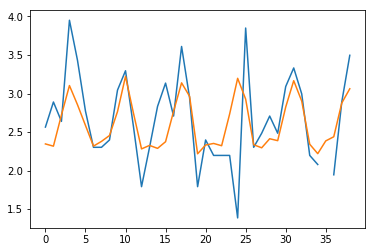

In [29]:
plt.plot(test_truth[129])
plt.plot(testpreds[129])

In [30]:
MSE(test_truth.reshape(-1),testpreds.reshape(-1))

0.280229282252979

In [31]:
np.sqrt(0.27809914084615828)

0.52735106034420587

In [32]:
lst=[]
for i in range(39):
    lst.append(MSE(test_truth[:,i],testpreds[:,i]))
    d=rrvf_data.idx_to_date([i+478-39])[0]
    print i, d, pd.to_datetime(d).weekday()+1, lst[-1]
np.mean(lst[:8]),np.mean(lst[:]),np.mean(lst[-8:])

0 2017-03-15 3 0.243185212761
1 2017-03-16 4 0.25076468293
2 2017-03-17 5 0.200861337259
3 2017-03-18 6 0.207271654397
4 2017-03-19 7 0.379941403767
5 2017-03-20 1 0.355754167312
6 2017-03-21 2 0.366173386565
7 2017-03-22 3 0.272837536038
8 2017-03-23 4 0.261583337904
9 2017-03-24 5 0.24876791222
10 2017-03-25 6 0.2376420211
11 2017-03-26 7 0.308200843532
12 2017-03-27 1 0.30917991746
13 2017-03-28 2 0.310275510762
14 2017-03-29 3 0.29521493117
15 2017-03-30 4 0.297012432993
16 2017-03-31 5 0.255695121943
17 2017-04-01 6 0.252561194106
18 2017-04-02 7 0.340655107017
19 2017-04-03 1 0.332605386259
20 2017-04-04 2 0.32167098895
21 2017-04-05 3 0.28814545827
22 2017-04-06 4 0.315139269698
23 2017-04-07 5 0.261335361474
24 2017-04-08 6 0.229643091383
25 2017-04-09 7 0.355415229938
26 2017-04-10 1 0.316506607271
27 2017-04-11 2 0.314392685465
28 2017-04-12 3 0.28180293552
29 2017-04-13 4 0.279201351883
30 2017-04-14 5 0.230685406244
31 2017-04-15 6 0.208042790963
32 2017-04-16 7 0.296222711

(0.28459867262864197, 0.28335532250754458, 0.26634201177518108)

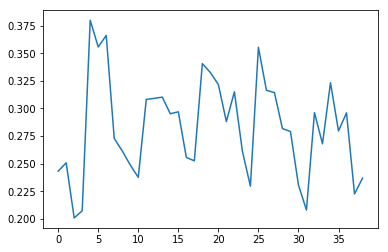

In [33]:
plt.plot(lst)

In [34]:
lst=[]
for i in range(test_truth.shape[0]):
    lst.append(MSE(test_truth[i],testpreds[i]))

/home/bo/anaconda2/envs/tensorflow14/lib/python2.7/site-packages/numpy/core/fromnumeric.py:2909: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/bo/anaconda2/envs/tensorflow14/lib/python2.7/site-packages/numpy/core/_methods.py:80: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


In [35]:
lst=np.array(lst)
lst[np.isnan(lst)]=5

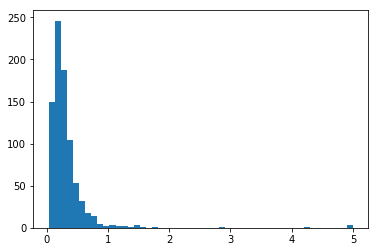

In [36]:
plt.hist(lst,bins=50);